In [1]:
from func import *

In [2]:
# Example tsv files
datasets = {
            'cnv': 'CNV_processedDat.txt',
            'mrna': 'mRNA_processedDat.txt',
            'prot': 'PROT_processedDat.txt'
}
        
labels = 'TCGA_BRCA_subtypes.txt'

Note: This is the same as voting.ipynb, except I try to do it all with dataset that is the same size.

In [3]:
_metrics={'f1':make_scorer(f1_score, average='weighted'),
         'accuracy':'accuracy'}

Loading the data:

In [20]:
data = {}
target = {}

train_data = {}
train_target = {}

eval_data = {}
eval_target = {}

for modality in datasets:
    data[modality], target[modality] = load_data(datasets[modality], labels)
    train_data[modality], eval_data[modality], train_target[modality], eval_target[modality] = train_test_split(data[modality], target[modality], test_size=0.2, train_size=0.8)

In [22]:
# Merge the data frames by the common index
data_merged = pd.merge(data['cnv'], data['mrna'], left_index=True, right_index=True)
data_merged = pd.merge(data_merged, data['prot'], left_index=True, right_index=True)
# Merge the data frames by the common index
target_merged = pd.merge(target['cnv'], target['mrna'], left_index=True, right_index=True)
target_merged = pd.merge(target_merged, target['prot'], left_index=True, right_index=True)

In [23]:
data['cnv'] = data_merged.iloc[:, :18799]
data['mrna'] = data_merged.iloc[:, 18799:36738]
data['prot'] = data_merged.iloc[:, 36738:44830]
target['cnv'] = target_merged.iloc[:, 0]
target['mrna'] = target_merged.iloc[:, 1]
target['prot'] = target_merged.iloc[:, 2]

print(data['cnv'].shape)
print(data['mrna'].shape)
print(data['prot'].shape)

(103, 18799)
(103, 17939)
(103, 8092)


Setting up the pipelines:

In [11]:
pipe_list = {}

# Setting up the pipes
for modality in datasets:
    pipes = {}

    for model in estimators:
        pipe=Pipeline(steps=[('data_prep',transformer),model])
        pipes[pipe.steps[1][0]]=pipe

    pipe_list[modality] = pipes

In [12]:
print(target['prot'].value_counts()[0])
print(target['prot'].value_counts()[1])
print(target['prot'].value_counts()[2])
print(target['prot'].value_counts()[3])

24
18
29
32


# Individual Model Scores

## Correlation Between Models:

In [10]:
ensemble_results_list = {}

for modality in datasets:
    ensemble_results=pd.DataFrame()
    print(modality)
    for name,pipe in pipe_list[modality].items():
        pipe.fit(train_data[modality], train_target[modality])
        ensemble_results[name]=pipe.predict(eval_data[modality])
    
    ensemble_results_list[modality] = ensemble_results

cnv


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


mrna
prot


<AxesSubplot: >

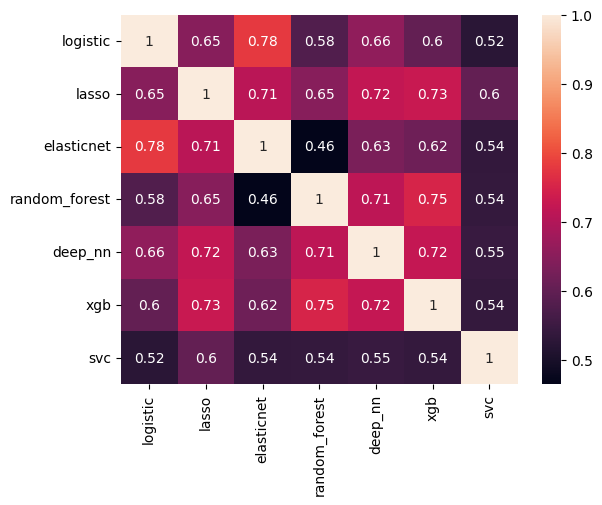

In [16]:
sns.heatmap(ensemble_results_list['cnv'].corr(),annot=True)

<AxesSubplot: >

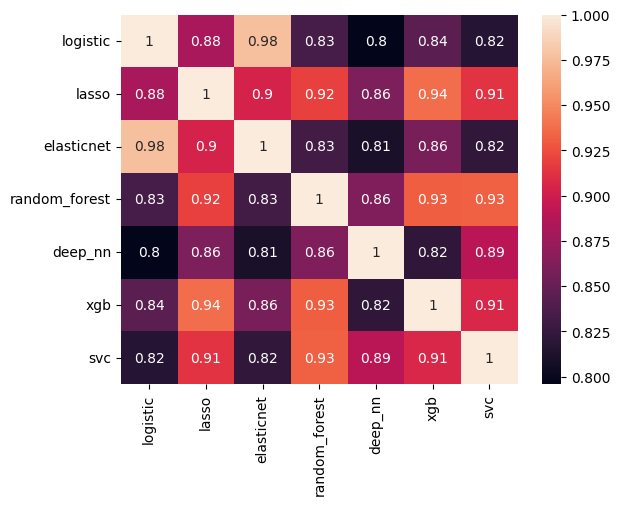

In [17]:
sns.heatmap(ensemble_results_list['mrna'].corr(),annot=True)

<AxesSubplot: >

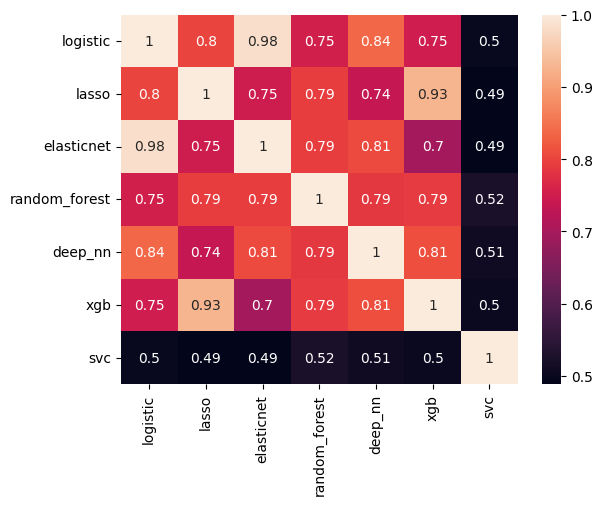

In [15]:
sns.heatmap(ensemble_results_list['prot'].corr(),annot=True)

In [16]:
data['cnv']

,A1BG_x,A2M_x,NAT1_x,NAT2_x,SERPINA3_x,AADAC,AAMP_x,AANAT_x,AARS_x,ABAT_x,...,LOC105376430,LOC105376575,LOC105376887,LOC105376948,LOC105377751,LOC105378220,KLF18,LOC105379861,BUB1B-PAK6,TBC1D7-LOC100130357
TCGA-A2-A0CM,0.0040,-0.0466,0.2010,0.2010,-0.0663,0.3186,0.0025,0.1049,0.1893,0.1681,...,0.1899,0.0556,0.0771,0.2054,-0.2867,-0.2738,0.0765,0.1899,-0.1169,0.1504
TCGA-A2-A0D0,-0.3603,0.1916,-0.3133,-0.3133,0.1406,0.9288,-0.3939,-0.2893,-0.2992,-0.3429,...,0.0783,-0.3271,-0.3158,-0.2931,-0.1815,-0.1571,0.4539,-0.3917,-0.2696,0.5007
TCGA-A2-A0D1,0.1567,0.1456,-0.6296,-0.6296,0.1493,-0.6130,0.1326,-0.1770,-0.1832,0.1445,...,0.1037,-0.6146,0.1519,0.1569,-0.1708,-0.1724,0.1410,0.1401,0.1364,0.1632
TCGA-A2-A0D2,0.3291,-0.1924,-0.2165,-0.2165,-0.2139,-0.1924,-0.1735,-0.0121,0.2035,-0.2574,...,0.5057,-0.2000,-0.2186,-0.1837,-0.2283,-0.2006,0.2133,0.1831,-0.2080,0.1533
TCGA-A2-A0EQ,-0.0093,-0.0022,-0.2430,-0.2430,-0.4348,-0.1178,-0.1144,0.3102,-0.1245,0.1000,...,0.1181,-0.1339,-0.0066,-0.1215,0.1157,-0.2520,-0.0066,0.1027,-0.2622,0.0050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-E2-A150,-0.5490,0.4561,-0.2757,-0.2757,0.0570,0.3621,0.0601,-0.2666,-0.0974,0.0254,...,0.6622,-0.2703,0.2410,0.3693,-0.4280,-0.4280,0.2410,0.0830,-0.4047,-0.3113
TCGA-E2-A154,0.0146,0.0064,0.3022,0.3022,0.0962,0.0726,-0.0396,-0.0123,-0.4970,0.4616,...,0.0787,-0.0232,-0.4637,0.0726,-0.0194,-0.0194,-0.4637,0.0856,-0.1101,-0.0359
TCGA-E2-A158,0.1918,0.1751,-0.7962,-0.7962,0.1807,0.6028,-0.7872,0.2210,0.1955,-0.7553,...,0.6972,-0.7423,0.2129,1.0946,-0.7500,-0.7824,0.1926,0.1811,-0.7694,0.1614
TCGA-E2-A159,0.2041,-0.1899,0.2057,0.2057,-0.1824,0.2023,-0.2012,-0.1251,-0.1952,-0.1952,...,0.5160,-0.2014,0.1976,0.2113,0.1429,0.1429,0.1861,-0.2041,-0.1909,0.1899


## Metrics:

In [13]:
col_names = ['model', 'f1', 'accuracy']
metrics = []
cross_val_list = {}
scorer_lists = {}

# Finding 5-fold cross-validated metrics for each model, for each dataset
for modality in datasets:
    
    cross_val = pd.DataFrame(columns=col_names)

    scorers = []

    for name, pipe in tqdm(pipe_list[modality].items()):
        
        cv = KFold(n_splits=5, random_state=1, shuffle=True)

        scores = cross_validate(pipe, data[modality], target[modality], scoring = _metrics, cv=cv)
        scorers.append(scores)
        
        cross_val = pd.concat([cross_val, pd.DataFrame([[name, "%0.3f +/- %0.3f" % (scores['test_f1'].mean(), scores['test_f1'].std()), "%0.3f +/- %0.3f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std())]], columns=col_names)], ignore_index=True)

    cross_val_list[modality] = cross_val
    scorer_lists[modality] = scorers

100%|██████████| 7/7 [00:33<00:00,  4.81s/it]


In [14]:
# Show scores
display(cross_val_list['cnv']), display(cross_val_list['mrna']), display(cross_val_list['prot'])

,model,f1,accuracy
0,logistic,0.524 +/- 0.092,0.564 +/- 0.075
1,lasso,0.607 +/- 0.121,0.623 +/- 0.108
2,elasticnet,0.567 +/- 0.075,0.574 +/- 0.072
3,random_forest,0.607 +/- 0.098,0.641 +/- 0.076
4,deep_nn,0.557 +/- 0.120,0.583 +/- 0.101
5,xgb,0.612 +/- 0.082,0.621 +/- 0.077
6,svc,0.468 +/- 0.060,0.495 +/- 0.035


,model,f1,accuracy
0,logistic,0.829 +/- 0.061,0.826 +/- 0.064
1,lasso,0.838 +/- 0.056,0.836 +/- 0.057
2,elasticnet,0.844 +/- 0.056,0.836 +/- 0.063
3,random_forest,0.776 +/- 0.065,0.778 +/- 0.054
4,deep_nn,0.759 +/- 0.104,0.768 +/- 0.096
5,xgb,0.729 +/- 0.149,0.730 +/- 0.159
6,svc,0.776 +/- 0.109,0.778 +/- 0.096


,model,f1,accuracy
0,logistic,0.570 +/- 0.103,0.564 +/- 0.107
1,lasso,0.601 +/- 0.098,0.603 +/- 0.091
2,elasticnet,0.582 +/- 0.143,0.574 +/- 0.155
3,random_forest,0.531 +/- 0.083,0.543 +/- 0.093
4,deep_nn,0.480 +/- 0.104,0.476 +/- 0.091
5,xgb,0.595 +/- 0.085,0.601 +/- 0.098
6,svc,0.478 +/- 0.079,0.514 +/- 0.045


(None, None, None)

In [24]:
estimator_names = ['logistic', 'lasso', 'elasticnet', 'random_forest', 'deep_nn', 'xgb', 'svc']

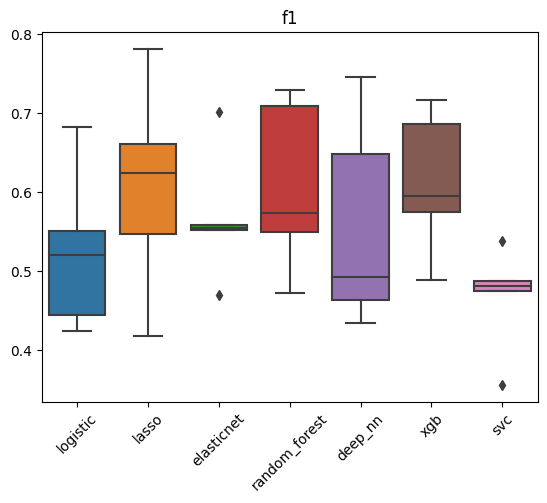

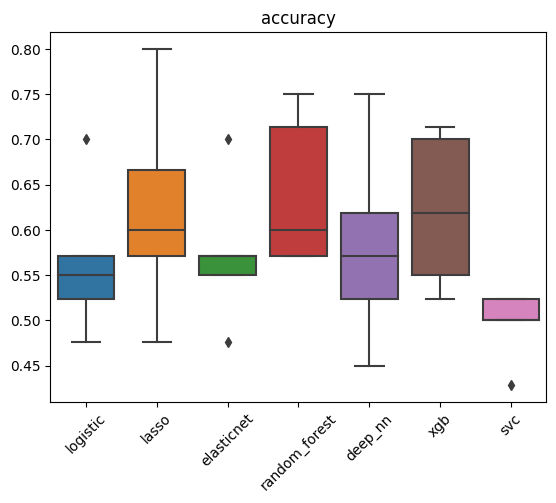

In [25]:
plot_scores(estimator_names, scorer_lists['cnv'])

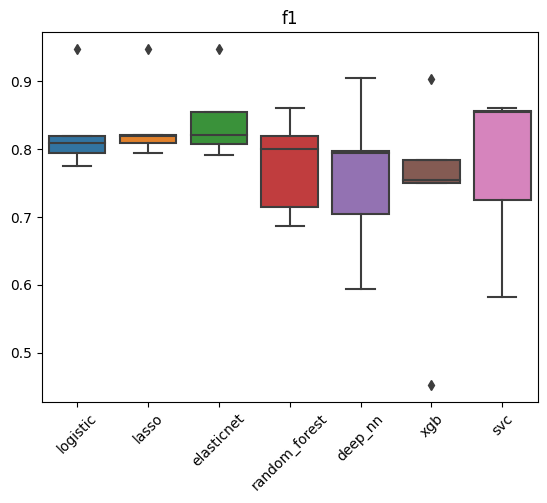

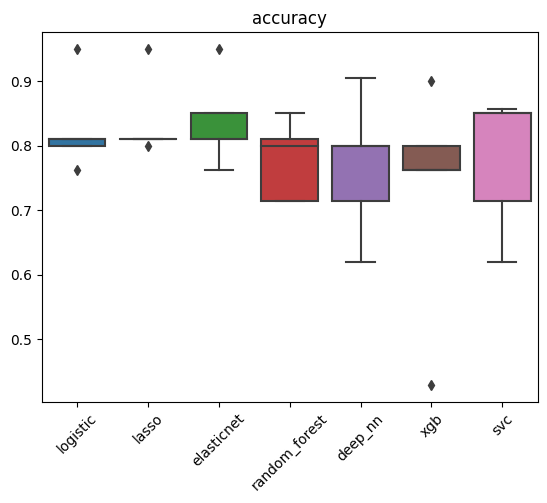

In [26]:
plot_scores(estimator_names, scorer_lists['mrna'])

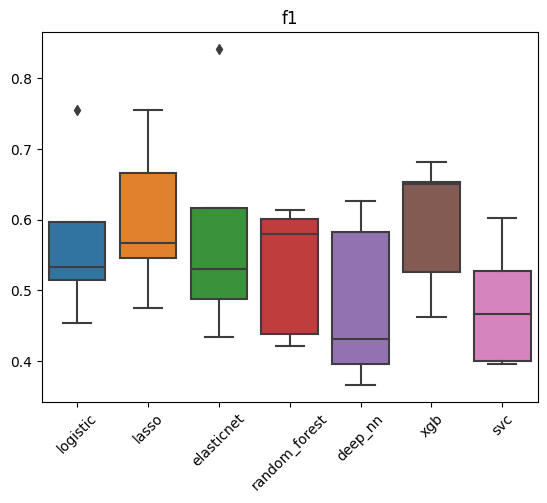

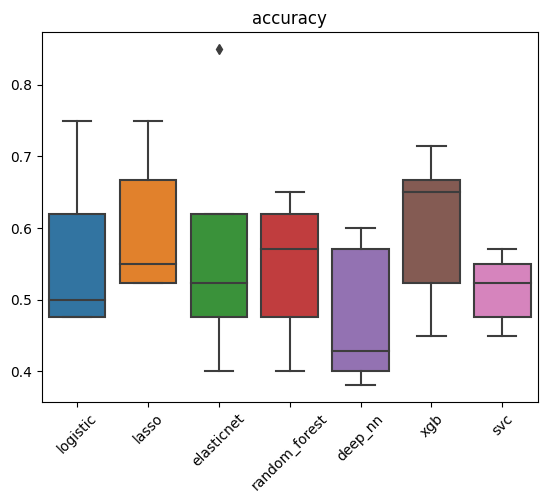

In [27]:
plot_scores(estimator_names, scorer_lists['prot'])

# Stacking Ensemble

### Logistic Regression as Meta Estimator:

In [28]:
# get a stacking ensemble of models
def trainStackingModel(pipes, final_estimator, data, target, metrics, cv):

    # Create the transformer to impute missing values
    imputer = SimpleImputer(strategy='mean')

    level1 = Pipeline(steps=[('prep', imputer), ('lr', final_estimator)])
    
     # calculating scores
    cv = KFold(n_splits=cv, random_state=1, shuffle=True)
    
    # define the stacking ensemble
    model = Pipeline(steps=[('data_prep',transformer),('stacking',StackingClassifier(estimators=pipes, final_estimator=level1, cv=cv))])

    scores = cross_validate(model, data, target, scoring=metrics, cv=cv, n_jobs=-1, error_score='raise')

    return model, scores

We will run the Stacking Classifier on the entire dataset, to get ensemble scores for each modality (5-fold cross validation).

In [29]:
col_names = ['model', 'f1', 'accuracy']
stacking_metrics = pd.DataFrame(columns=col_names)
stacking_model = {}
scores = {}

for modality in datasets:
    print("dataset: " + modality)

    stacking_model[modality], scores[modality] = trainStackingModel(estimators, LogisticRegression(), data[modality], target[modality], metrics=_metrics, cv=5)

    stacking_metrics = pd.concat([stacking_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores[modality]['test_f1']), np.std(scores[modality]['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores[modality]['test_accuracy']), np.std(scores[modality]['test_accuracy']))]], columns=col_names)], ignore_index=True)

dataset: cnv


/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_base.py:440: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


dataset: mrna
dataset: prot


/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_base.py:440: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


In [30]:
stacking_metrics

,model,f1,accuracy
0,cnv,0.700 +/- 0.060,0.708 +/- 0.056
1,mrna,0.832 +/- 0.060,0.826 +/- 0.064
2,prot,0.599 +/- 0.089,0.602 +/- 0.093


In [31]:
modalities=['cnv', 'mRNA', 'prot']
scorers = []
scorers.append(scores['cnv'])
scorers.append(scores['mrna'])
scorers.append(scores['prot'])

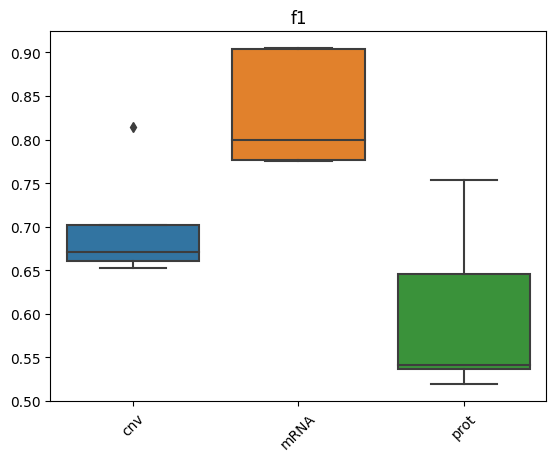

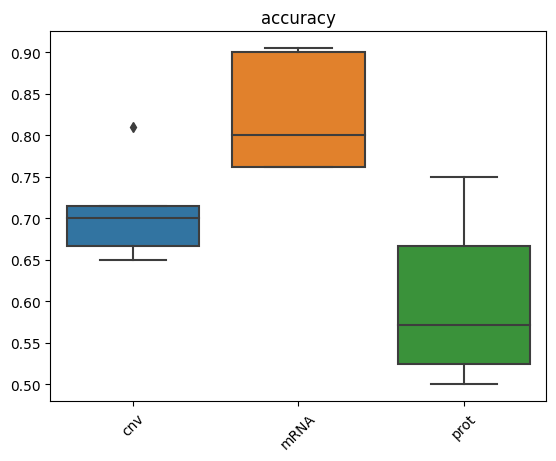

In [32]:
plot_scores(modalities, scorers)

In [33]:
estimator_lists = ['logistic', 'lasso', 'elasticnet', 'random_forest', 'deep_nn', 'xgb', 'svc', 'stacking']

scorer_lists['cnv'].append(scores['cnv'])
scorer_lists['mrna'].append(scores['mrna'])
scorer_lists['prot'].append(scores['prot'])

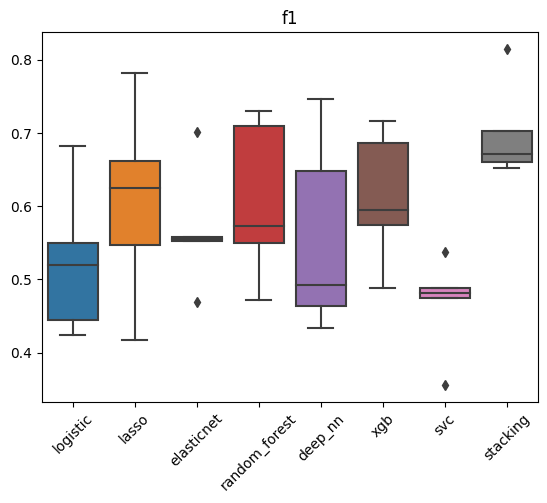

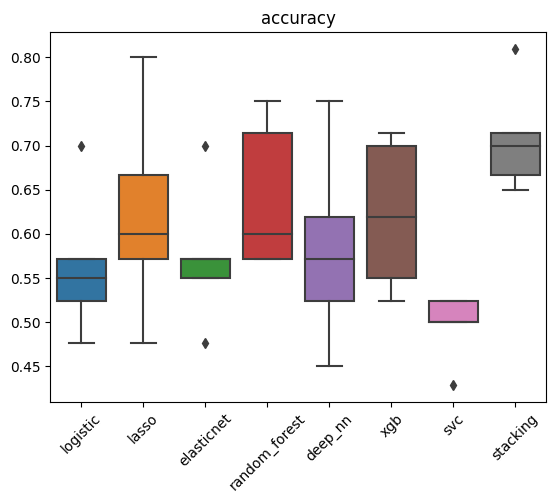

In [34]:
plot_scores(estimator_lists, scorer_lists['cnv'])

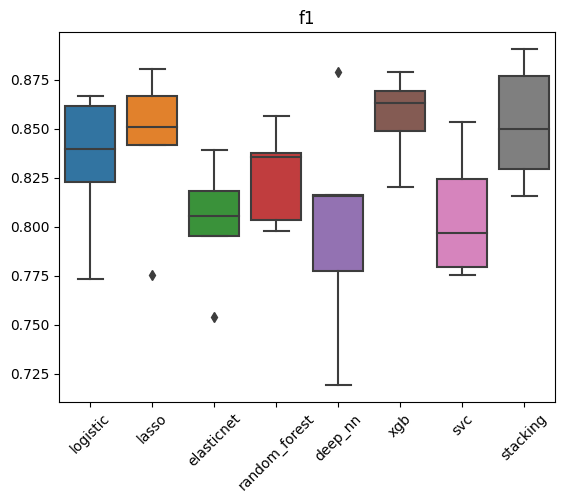

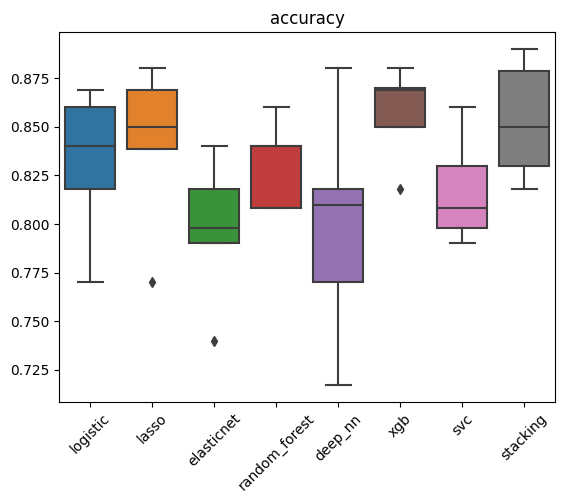

In [19]:
plot_scores(estimator_lists, scorer_lists['mrna'])

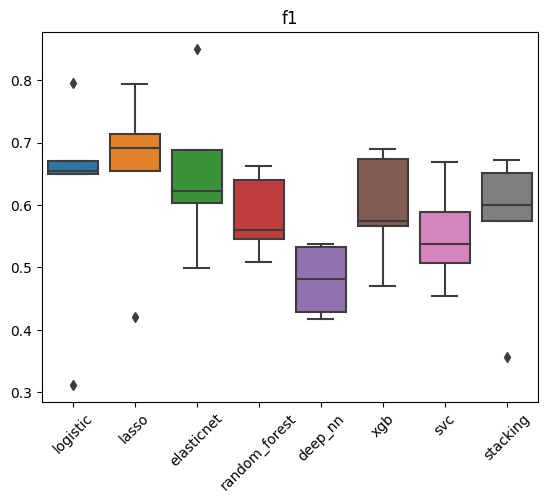

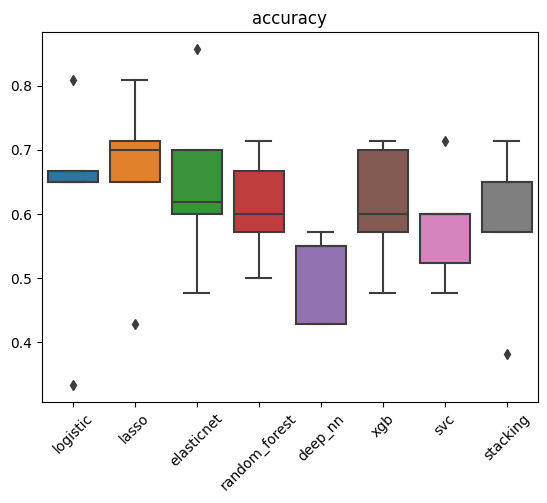

In [20]:
plot_scores(estimator_lists, scorer_lists['prot'])

# Reduced Features via SelectFromModel

In [35]:
# Setting up new results df
data_reduced = {}
col_names = ['model', 'f1', 'accuracy']
reduced_metrics = pd.DataFrame(columns=col_names)

In [36]:
# Reducing featuers for each modality, using L2 regularization
for modality in datasets:
    
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    
    clf = LogisticRegressionCV(penalty='l2', cv=cv)

    # Use SelectFromModel to select the most important features based on the L2 regularization
    selector = SelectFromModel(clf)
    selector.fit(data[modality], target[modality])
    selected_feats = data[modality].columns[(selector.get_support())]
    
    print(modality)
    print('Total features: {}'.format((data[modality].shape[1])))
    print('selected features: {}'.format(len(selected_feats)))
    
    # Creating reduced dataset
    data_reduced[modality]=data[modality][selected_feats]


cnv
Total features: 18799
selected features: 8136
mrna
Total features: 17939
selected features: 6430
prot
Total features: 8092
selected features: 3132


### Individual Models

In [37]:
metrics = []
cross_val_list = {}
scorer_lists = {}

# Finding 5-fold cross-validated metrics for each model, for each dataset
for modality in datasets:
    
    cross_val = pd.DataFrame(columns=col_names)

    scorers = []
    
    cv = KFold(n_splits=5, random_state=1, shuffle=True)

    for name, pipe in tqdm(pipe_list[modality].items()):

        scores = cross_validate(pipe, data_reduced[modality], target[modality], scoring = _metrics, cv=cv)
        scorers.append(scores)
        
        cross_val = pd.concat([cross_val, pd.DataFrame([[name, "%0.3f +/- %0.3f" % (scores['test_f1'].mean(), scores['test_f1'].std()), "%0.3f +/- %0.3f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std())]], columns=col_names)], ignore_index=True)

    cross_val_list[modality] = cross_val
    scorer_lists[modality] = scorers

100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


In [38]:
# Show scores
display(cross_val_list['cnv']), display(cross_val_list['mrna']), display(cross_val_list['prot'])

,model,f1,accuracy
0,logistic,0.715 +/- 0.145,0.731 +/- 0.128
1,lasso,0.696 +/- 0.099,0.700 +/- 0.099
2,elasticnet,0.725 +/- 0.105,0.730 +/- 0.104
3,random_forest,0.665 +/- 0.116,0.690 +/- 0.097
4,deep_nn,0.698 +/- 0.077,0.710 +/- 0.063
5,xgb,0.661 +/- 0.122,0.672 +/- 0.114
6,svc,0.586 +/- 0.086,0.622 +/- 0.060


,model,f1,accuracy
0,logistic,0.925 +/- 0.047,0.923 +/- 0.049
1,lasso,0.915 +/- 0.045,0.913 +/- 0.047
2,elasticnet,0.944 +/- 0.054,0.942 +/- 0.055
3,random_forest,0.858 +/- 0.057,0.854 +/- 0.052
4,deep_nn,0.880 +/- 0.087,0.884 +/- 0.084
5,xgb,0.738 +/- 0.107,0.739 +/- 0.113
6,svc,0.922 +/- 0.021,0.923 +/- 0.022


,model,f1,accuracy
0,logistic,0.813 +/- 0.077,0.817 +/- 0.076
1,lasso,0.704 +/- 0.064,0.700 +/- 0.068
2,elasticnet,0.800 +/- 0.091,0.805 +/- 0.095
3,random_forest,0.581 +/- 0.094,0.592 +/- 0.080
4,deep_nn,0.728 +/- 0.095,0.730 +/- 0.095
5,xgb,0.594 +/- 0.132,0.591 +/- 0.149
6,svc,0.713 +/- 0.100,0.738 +/- 0.073


(None, None, None)

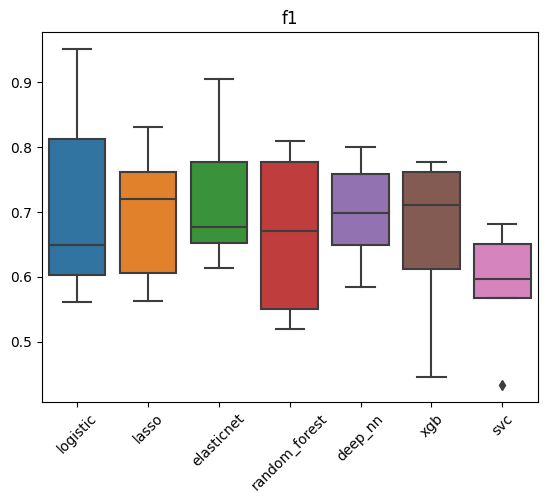

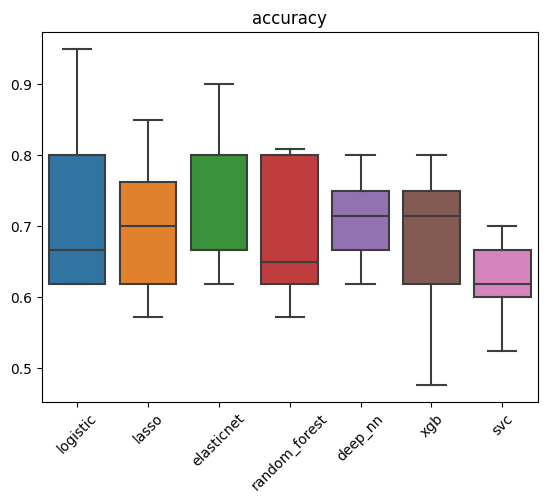

In [39]:
estimator_lists = ['logistic', 'lasso', 'elasticnet', 'random_forest', 'deep_nn', 'xgb', 'svc']
plot_scores(estimator_lists, scorer_lists['cnv'])

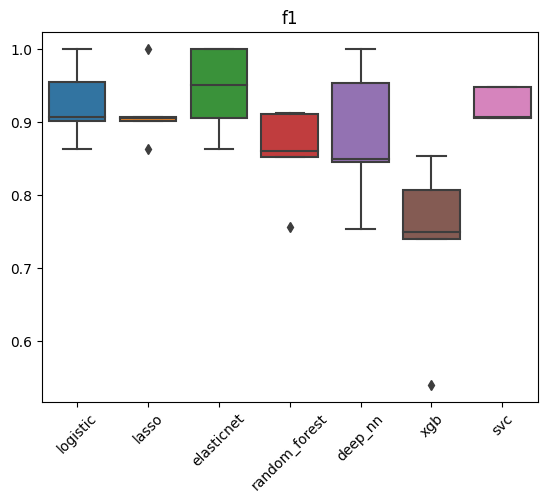

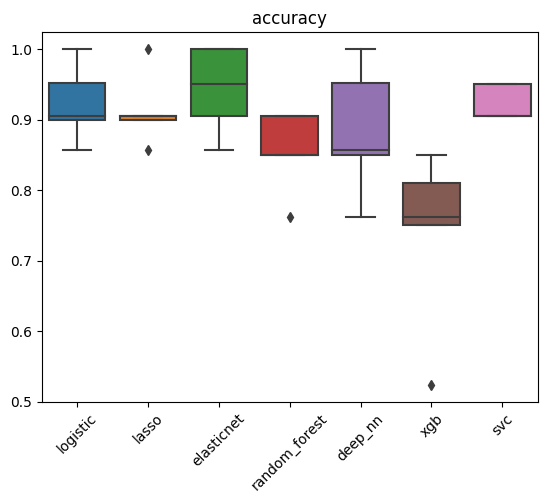

In [40]:
plot_scores(estimator_lists, scorer_lists['mrna'])

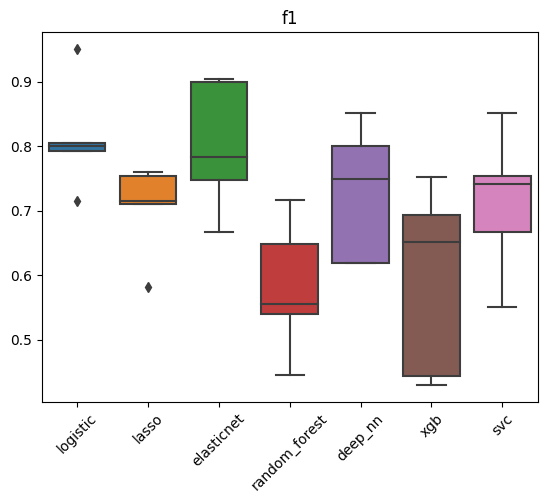

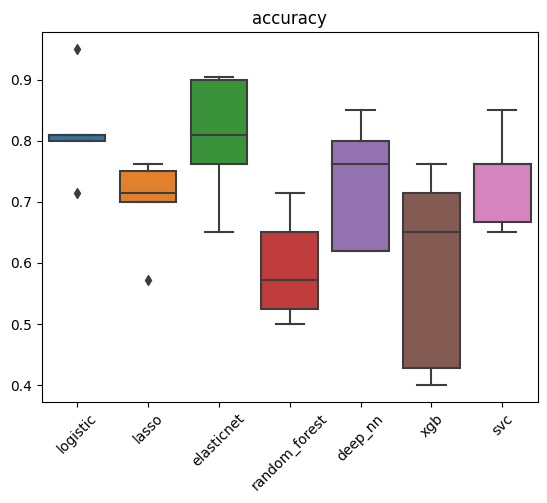

In [41]:
plot_scores(estimator_lists, scorer_lists['prot'])

### Ensemble

In [42]:
reduced_stacking_metrics = pd.DataFrame(columns=col_names)
stacking_model = {}
scores = {}

selected_estimators = ['logistic', 'lasso', 'elasticnet', 'random_forest', 'xgb', 'deep_nn', 'svc']

for modality in datasets:
    print("dataset: " + modality)
    
    estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators if x == name)]
    
    stacking_model[modality], scores[modality] = trainStackingModel(estimator_list, LogisticRegression(), data_reduced[modality], target[modality], metrics=_metrics, cv=5)

    reduced_stacking_metrics = pd.concat([reduced_stacking_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores[modality]['test_f1']), np.std(scores[modality]['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores[modality]['test_accuracy']), np.std(scores[modality]['test_accuracy']))]], columns=col_names)], ignore_index=True)

dataset: cnv
dataset: mrna
dataset: prot


In [43]:
reduced_stacking_metrics

,model,f1,accuracy
0,cnv,0.737 +/- 0.118,0.740 +/- 0.112
1,mrna,0.915 +/- 0.045,0.913 +/- 0.047
2,prot,0.731 +/- 0.098,0.749 +/- 0.079


## Reduced Estimators:

Ensemble model is still not better than best performing base estimator. We can try and improve this by trying combinations of estimators:

### Testing Combinations

In [44]:
from itertools import combinations
col_names = ['model', 'f1', 'accuracy']

In [45]:
def test_combos(names, data, target, estimators=estimators):
    stacking_metrics = pd.DataFrame(columns=col_names)

    combos=[]
    for L in range(2, len(names)+1):
        for subset in combinations(names, L):
            combos.append(list(subset))
            
    for combo in combos:
        estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in combo if x == name)]
        
        print('testing combo: ' + str(combo))
        stacking_model, combo_scores = trainStackingModel(estimator_list, LogisticRegression(), data, target, metrics=_metrics, cv=5)
        stacking_metrics = pd.concat([stacking_metrics, pd.DataFrame([[str(combo), '%.3f +/- %.3f' %(np.mean(combo_scores['test_f1']), np.std(combo_scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(combo_scores['test_accuracy']), np.std(combo_scores['test_accuracy']))]], columns=col_names)], ignore_index=True)
    
    return stacking_metrics

In [ ]:
# cnv estimators

estimator_names = ['logistic', 'lasso', 'elasticnet', 'deep_nn', 'random_forest']

stacking_metrics = pd.DataFrame(columns=col_names)

stacking_metrics = test_combos(estimator_names, data_reduced['cnv'], target['cnv'])

testing combo: ['logistic', 'lasso']
testing combo: ['logistic', 'elasticnet']
testing combo: ['logistic', 'deep_nn']
testing combo: ['logistic', 'random_forest']
testing combo: ['lasso', 'elasticnet']
testing combo: ['lasso', 'deep_nn']
testing combo: ['lasso', 'random_forest']
testing combo: ['elasticnet', 'deep_nn']
testing combo: ['elasticnet', 'random_forest']
testing combo: ['deep_nn', 'random_forest']
testing combo: ['logistic', 'lasso', 'elasticnet']
testing combo: ['logistic', 'lasso', 'deep_nn']
testing combo: ['logistic', 'lasso', 'random_forest']
testing combo: ['logistic', 'elasticnet', 'deep_nn']
testing combo: ['logistic', 'elasticnet', 'random_forest']
testing combo: ['logistic', 'deep_nn', 'random_forest']
testing combo: ['lasso', 'elasticnet', 'deep_nn']
testing combo: ['lasso', 'elasticnet', 'random_forest']
testing combo: ['lasso', 'deep_nn', 'random_forest']
testing combo: ['elasticnet', 'deep_nn', 'random_forest']
testing combo: ['logistic', 'lasso', 'elasticnet',

In [ ]:
stacking_metrics.sort_values('f1', ascending=False)

In [49]:
# mRNA estimators

estimator_names = ['logistic', 'lasso', 'elasticnet', 'deep_nn', 'svc']

stacking_metrics = pd.DataFrame(columns=col_names)

stacking_metrics = test_combos(estimator_names, data_reduced['mrna'], target['mrna'])

testing combo: ['logistic', 'lasso']
testing combo: ['logistic', 'elasticnet']
testing combo: ['logistic', 'deep_nn']
testing combo: ['logistic', 'svc']
testing combo: ['lasso', 'elasticnet']
testing combo: ['lasso', 'deep_nn']
testing combo: ['lasso', 'svc']
testing combo: ['elasticnet', 'deep_nn']
testing combo: ['elasticnet', 'svc']
testing combo: ['deep_nn', 'svc']
testing combo: ['logistic', 'lasso', 'elasticnet']
testing combo: ['logistic', 'lasso', 'deep_nn']
testing combo: ['logistic', 'lasso', 'svc']
testing combo: ['logistic', 'elasticnet', 'deep_nn']
testing combo: ['logistic', 'elasticnet', 'svc']
testing combo: ['logistic', 'deep_nn', 'svc']
testing combo: ['lasso', 'elasticnet', 'deep_nn']
testing combo: ['lasso', 'elasticnet', 'svc']
testing combo: ['lasso', 'deep_nn', 'svc']
testing combo: ['elasticnet', 'deep_nn', 'svc']
testing combo: ['logistic', 'lasso', 'elasticnet', 'deep_nn']
testing combo: ['logistic', 'lasso', 'elasticnet', 'svc']
testing combo: ['logistic', 'l

In [50]:
stacking_metrics.sort_values('f1', ascending=False)

,model,f1,accuracy
0,"['logistic', 'lasso']",0.925 +/- 0.047,0.923 +/- 0.049
3,"['logistic', 'svc']",0.925 +/- 0.047,0.923 +/- 0.049
21,"['logistic', 'lasso', 'elasticnet', 'svc']",0.925 +/- 0.047,0.923 +/- 0.049
14,"['logistic', 'elasticnet', 'svc']",0.925 +/- 0.047,0.923 +/- 0.049
1,"['logistic', 'elasticnet']",0.925 +/- 0.047,0.923 +/- 0.049
12,"['logistic', 'lasso', 'svc']",0.925 +/- 0.047,0.923 +/- 0.049
10,"['logistic', 'lasso', 'elasticnet']",0.925 +/- 0.047,0.923 +/- 0.049
15,"['logistic', 'deep_nn', 'svc']",0.924 +/- 0.038,0.923 +/- 0.039
11,"['logistic', 'lasso', 'deep_nn']",0.914 +/- 0.047,0.913 +/- 0.047
22,"['logistic', 'lasso', 'deep_nn', 'svc']",0.914 +/- 0.047,0.913 +/- 0.047


For mRNA, the best estimators are 'logistic' and 'deep_nn'.

In [51]:
# prot estimators

estimator_names = ['logistic', 'lasso', 'elasticnet', 'deep_nn', 'svc']

stacking_metrics = pd.DataFrame(columns=col_names)

stacking_metrics = test_combos(estimator_names, data_reduced['prot'], target['prot'])

testing combo: ['logistic', 'lasso']
testing combo: ['logistic', 'elasticnet']
testing combo: ['logistic', 'deep_nn']
testing combo: ['logistic', 'svc']
testing combo: ['lasso', 'elasticnet']
testing combo: ['lasso', 'deep_nn']
testing combo: ['lasso', 'svc']
testing combo: ['elasticnet', 'deep_nn']
testing combo: ['elasticnet', 'svc']
testing combo: ['deep_nn', 'svc']
testing combo: ['logistic', 'lasso', 'elasticnet']
testing combo: ['logistic', 'lasso', 'deep_nn']
testing combo: ['logistic', 'lasso', 'svc']
testing combo: ['logistic', 'elasticnet', 'deep_nn']
testing combo: ['logistic', 'elasticnet', 'svc']
testing combo: ['logistic', 'deep_nn', 'svc']
testing combo: ['lasso', 'elasticnet', 'deep_nn']
testing combo: ['lasso', 'elasticnet', 'svc']
testing combo: ['lasso', 'deep_nn', 'svc']
testing combo: ['elasticnet', 'deep_nn', 'svc']
testing combo: ['logistic', 'lasso', 'elasticnet', 'deep_nn']
testing combo: ['logistic', 'lasso', 'elasticnet', 'svc']
testing combo: ['logistic', 'l

In [52]:
stacking_metrics.sort_values('f1', ascending=False)

,model,f1,accuracy
1,"['logistic', 'elasticnet']",0.774 +/- 0.101,0.787 +/- 0.083
3,"['logistic', 'svc']",0.771 +/- 0.106,0.788 +/- 0.087
12,"['logistic', 'lasso', 'svc']",0.771 +/- 0.106,0.788 +/- 0.087
0,"['logistic', 'lasso']",0.764 +/- 0.115,0.778 +/- 0.096
10,"['logistic', 'lasso', 'elasticnet']",0.763 +/- 0.104,0.778 +/- 0.088
21,"['logistic', 'lasso', 'elasticnet', 'svc']",0.761 +/- 0.108,0.778 +/- 0.088
14,"['logistic', 'elasticnet', 'svc']",0.761 +/- 0.108,0.778 +/- 0.088
23,"['logistic', 'elasticnet', 'deep_nn', 'svc']",0.757 +/- 0.088,0.769 +/- 0.080
20,"['logistic', 'lasso', 'elasticnet', 'deep_nn']",0.757 +/- 0.088,0.769 +/- 0.080
13,"['logistic', 'elasticnet', 'deep_nn']",0.757 +/- 0.088,0.769 +/- 0.080


For prot, the best performing combo is logistic and elasticnet.

In [7]:
# Dictionary of best estimators for each modality
selected_estimators = {
    'cnv': ['logistic', 'xgb', 'deep_nn'],
    'mrna': ['logistic', 'deep_nn'],
    'prot': ['logistic', 'elasticnet']
}

In [42]:
reduced_stacking_metrics = pd.DataFrame(columns=col_names)
stacking_model = {}
scores = {}

for modality in datasets:
    print("dataset: " + modality)
    
    estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators[modality] if x == name)]
    
    stacking_model[modality], scores[modality] = trainStackingModel(estimator_list, LogisticRegression(), data_reduced[modality], target[modality], metrics=_metrics, cv=5)

    reduced_stacking_metrics = pd.concat([reduced_stacking_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores[modality]['test_f1']), np.std(scores[modality]['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores[modality]['test_accuracy']), np.std(scores[modality]['test_accuracy']))]], columns=col_names)], ignore_index=True)

dataset: cnv
dataset: mrna
dataset: prot


In [43]:
reduced_stacking_metrics

,model,f1,accuracy
0,cnv,0.737 +/- 0.029,0.748 +/- 0.035
1,mrna,0.926 +/- 0.022,0.926 +/- 0.021
2,prot,0.860 +/- 0.083,0.863 +/- 0.080


In [44]:
estimator_lists = ['logistic', 'lasso', 'elasticnet', 'random_forest', 'deep_nn', 'xgb', 'svc', 'stacking']

scorer_lists['cnv'].append(scores['cnv'])
scorer_lists['mrna'].append(scores['mrna'])
scorer_lists['prot'].append(scores['prot'])

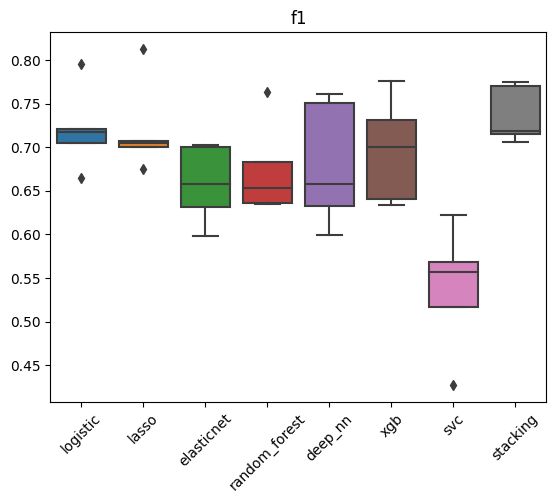

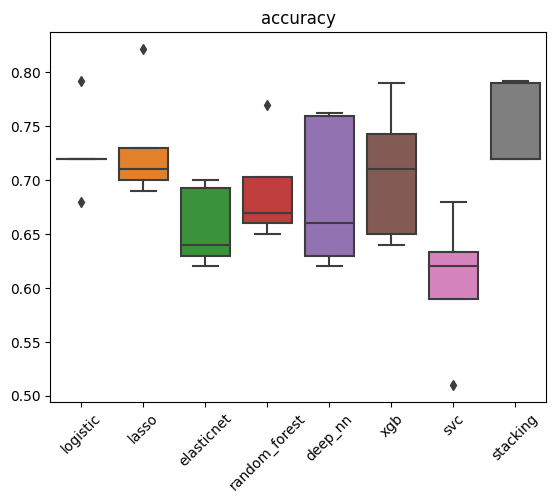

In [45]:
plot_scores(estimator_lists, scorer_lists['cnv'])

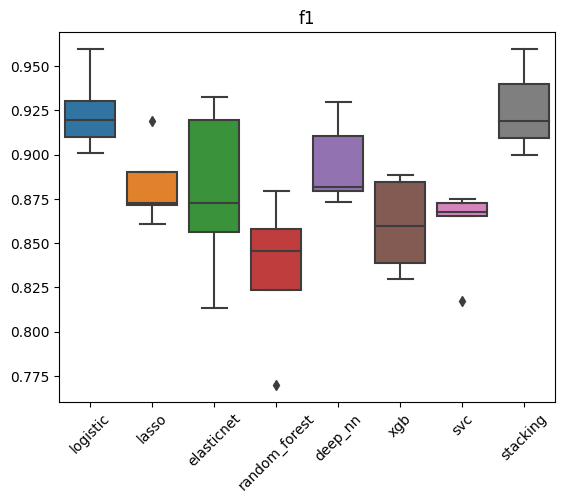

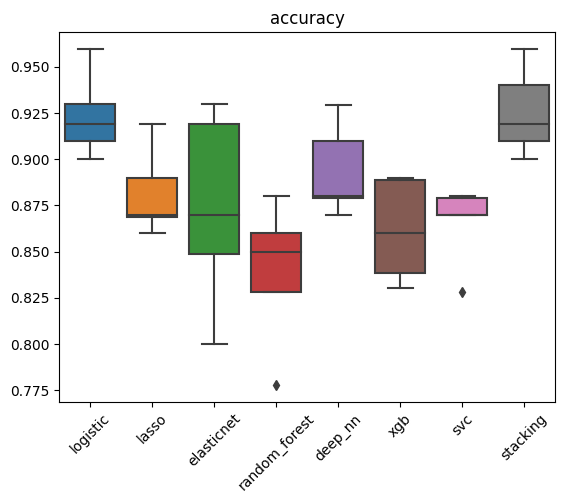

In [46]:
plot_scores(estimator_lists, scorer_lists['mrna'])

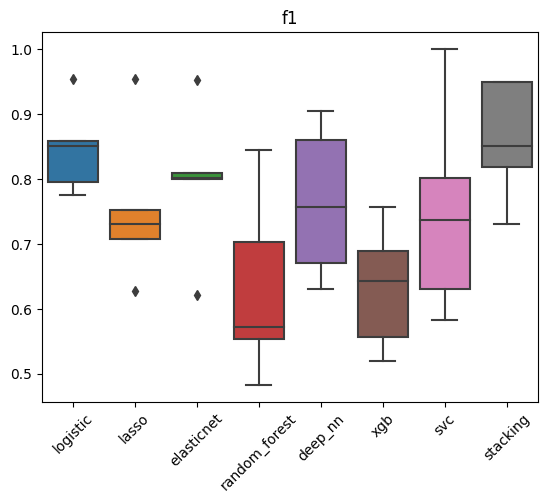

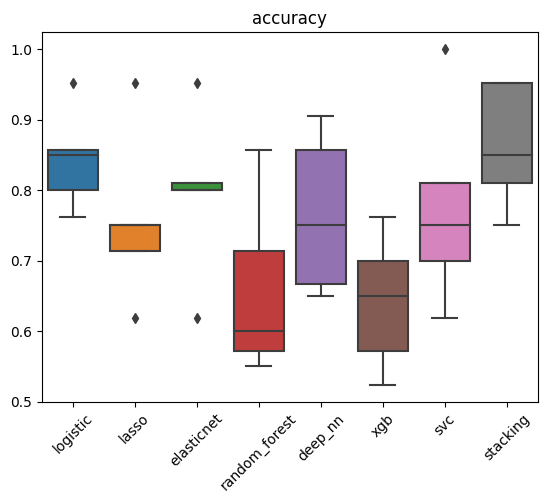

In [47]:
plot_scores(estimator_lists, scorer_lists['prot'])

# Feature Selection

In [8]:
new_data = {}

## cnv

In [77]:
import warnings
warnings.filterwarnings('ignore')

estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['cnv'] if x == name)]

'''# Create the transformer to impute missing values
imputer = SimpleImputer(strategy='mean')
level1 = Pipeline(steps=[('prep', imputer), ('lr', LogisticRegression())])

cv = KFold(n_splits = 3, random_state=1, shuffle=True)

model = StackingClassifier(estimator_list, final_estimator=level1, cv='prefit')'''

fs_cnv = FeatureSelection(estimator_list, 3)
fs_cnv.fit(data_reduced['cnv'], target['cnv'])

100%|██████████| 7991/7991 [58:39<00:00,  2.27it/s]  


In [81]:
# Finding the 100 most important features
indices = fs_cnv.best_n_features(100)
columns = data_reduced['cnv'].columns[indices]
print(columns)

Index(['XRCC4', 'RASEF', 'SGCA', 'FRMD3', 'COX11', 'NUAK1', 'ADAP2', 'ATP6V0C',
       'KCNJ16', 'LGALS9', 'SGSM2', 'LGR5', 'TPBG', 'CAMTA2', 'PHOSPHO1',
       'NPEPPS', 'AVPR1B', 'ZDHHC21', 'EME1', 'PPP1R9B', 'ANKRD40', 'MTRNR2L4',
       'MTRNR2L3', 'UQCRFS1', 'TMEM132C', 'TMEM92', 'UBQLN1', 'SPO11',
       'ANKFY1', 'AHSP', 'TCP11L2', 'KLHL4', 'GCNT2', 'GPR27', 'CACNG1',
       'SPAG9', 'RNF135', 'CNTROB', 'KPNB1', 'RAE1', 'STAU1', 'WFIKKN2',
       'TMEM88', 'KIF2B', 'GSG1L', 'IDNK', 'IKZF3', 'PTPRQ', 'RBM38', 'NEURL4',
       'TRAPPC1', 'CCDC85A', 'GKAP1', 'KRT24', 'HSPA14', 'GLT1D1', 'TPSG1',
       'ZNF652', 'RAD9B', 'ITGAD', 'KIF1C', 'CYB5D1', 'TGIF1', 'SLC15A4',
       'INCA1', 'PAH', 'ABCC3', 'TOM1L1', 'NLGN4X', 'COL1A1', 'TGIF2LX',
       'CCT2', 'C11orf54', 'RASSF9', 'LYZ', 'CEP112', 'FRS2', 'YEATS4',
       'CORO1C', 'SNX22', 'SAXO1', 'RNPEP', 'NAGS', 'FAM134C', 'RPS6', 'RLN2',
       'RPS2', 'RLF', 'DAPK2', 'RIT1', 'THNSL1', 'EPHX3', 'RPL19', 'ROCK1',
       'CFAP69', 'R

In [79]:
','.join(columns)

'XRCC4,RASEF,SGCA,FRMD3,COX11,NUAK1,ADAP2,ATP6V0C,KCNJ16,LGALS9,SGSM2,LGR5,TPBG,CAMTA2,PHOSPHO1,NPEPPS,AVPR1B,ZDHHC21,EME1,PPP1R9B,ANKRD40,MTRNR2L4,MTRNR2L3,UQCRFS1,TMEM132C,TMEM92,UBQLN1,SPO11,ANKFY1,AHSP,TCP11L2,KLHL4,GCNT2,GPR27,CACNG1,SPAG9,RNF135,CNTROB,KPNB1,RAE1,STAU1,WFIKKN2,TMEM88,KIF2B,GSG1L,IDNK,IKZF3,PTPRQ,RBM38,NEURL4,TRAPPC1,CCDC85A,GKAP1,KRT24,HSPA14,GLT1D1,TPSG1,ZNF652,RAD9B,ITGAD,KIF1C,CYB5D1,TGIF1,SLC15A4,INCA1,PAH,ABCC3,TOM1L1,NLGN4X,COL1A1,TGIF2LX,CCT2,C11orf54,RASSF9,LYZ,CEP112,FRS2,YEATS4,CORO1C,SNX22,SAXO1,RNPEP,NAGS,FAM134C,RPS6,RLN2,RPS2,RLF,DAPK2,RIT1,THNSL1,EPHX3,RPL19,ROCK1,CFAP69,RPAP2,PPTC7,EML5,RPL5,RPS8'

In [78]:
# Get scores of all subsets of features
fs_cnv.get_scores(data_reduced['cnv'], target['cnv'], 1000)

100%|██████████| 1000/1000 [01:26<00:00, 11.51it/s]


array([0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508

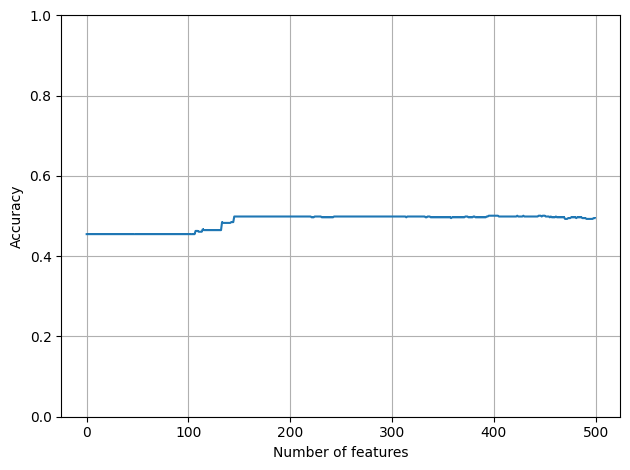

In [74]:
fs_cnv.plot_scores(500)

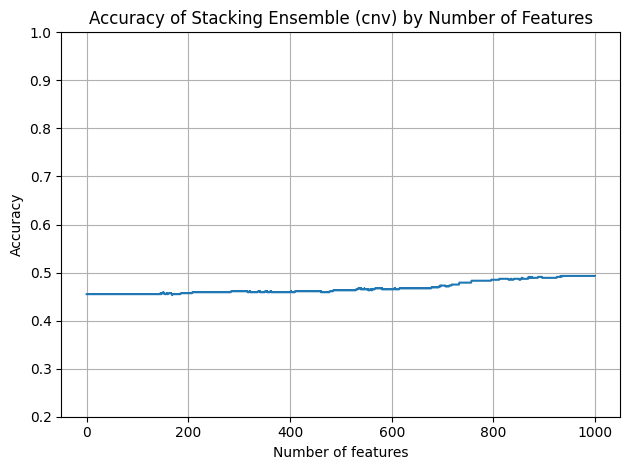

In [79]:
x = list(range(1000))
plt.plot(x, fs_cnv.scores_, marker=',')
plt.ylim([0.2, 1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.title('Accuracy of Stacking Ensemble (cnv) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [82]:
scores = get_score_range(fs_cnv, estimator_list, data_reduced['cnv'], target['cnv'], 0, 7991)

100%|██████████| 7991/7991 [27:58<00:00,  4.76it/s]


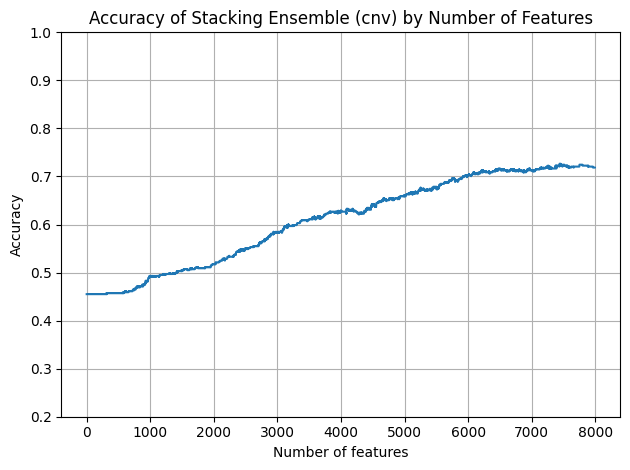

In [83]:
x = list(range(0, 7991))
plt.plot(x, scores, marker=',')
plt.ylim([0.2, 1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.title('Accuracy of Stacking Ensemble (cnv) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [84]:
n_features = np.argmax(scores)
print(n_features)

7438


In [89]:
features = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7500, 8000]
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['cnv'] if x == name)]

for n in tqdm(features):
    
    indices = fs_cnv.best_n_features(n)
    columns = data_reduced['cnv'].columns[indices]

    new_data['cnv'] = data_reduced['cnv'].loc[:, columns]
    
    # Perform 5-fold cross-validation
    model, scores = trainStackingModel(estimator_list, LogisticRegression(), new_data['cnv'], target['cnv'], metrics={'f1':make_scorer(f1_score, average='weighted'),
             'accuracy':'accuracy'}, cv=5)

    metrics = pd.concat([metrics, pd.DataFrame([[n, '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)

metrics

100%|██████████| 14/14 [41:10<00:00, 176.49s/it]


,model,f1_score,accuracy
0,1000,0.726 +/- 0.039,0.736 +/- 0.039
1,1500,0.697 +/- 0.048,0.714 +/- 0.053
2,2000,0.730 +/- 0.038,0.742 +/- 0.039
3,2500,0.722 +/- 0.045,0.732 +/- 0.048
4,3000,0.731 +/- 0.047,0.740 +/- 0.051
5,3500,0.728 +/- 0.039,0.738 +/- 0.045
6,4000,0.748 +/- 0.027,0.758 +/- 0.031
7,4500,0.735 +/- 0.030,0.746 +/- 0.033
8,5000,0.725 +/- 0.029,0.736 +/- 0.034
9,5500,0.725 +/- 0.039,0.736 +/- 0.041


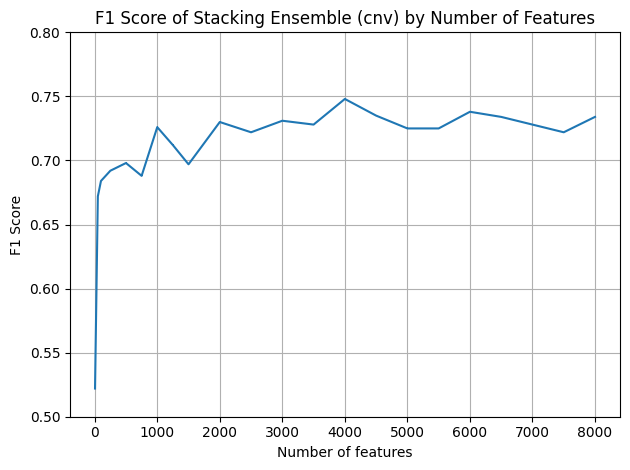

In [54]:
x = [5, 50, 100, 250, 500, 750, 1000, 1250, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7500, 8000]
y = [0.522, 0.672, 0.684, 0.692, 0.698, 0.688, 0.726, 0.712, 0.697, 0.730, 0.722, 0.731, 0.728, 0.748, 0.735, 0.725, 0.725, 0.738, 0.734, 0.722, 0.734]
plt.plot(x, y, marker=',')
plt.ylim([0.5, 0.8])
plt.ylabel('F1 Score')
plt.xlabel('Number of features')
plt.title('F1 Score of Stacking Ensemble (cnv) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

Top scoring number of features is 4000.

In [39]:
cnv = pd.read_pickle("cnv_reduced.pkl")

In [56]:
# Finding the n most important features based on plot
#indices = fs_cnv.best_n_features(4000)
#columns = data_reduced['cnv'].columns[indices]

#new_data['cnv'] = data_reduced['cnv'].loc[:, columns]

col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)

estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['cnv'] if x == name)]

# Perform 5-fold cross-validation
model, scores = trainStackingModel(estimator_list, LogisticRegression(), cnv.iloc[:, : 4000], target['cnv'], metrics={'f1':make_scorer(f1_score, average='weighted'),
         'accuracy':'accuracy'}, cv=5)

metrics = pd.concat([metrics, pd.DataFrame([['cnv', '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)

metrics

/opt/tljh/user/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/opt/tljh/user/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

In [93]:
new_data['cnv'].to_pickle("cnv_reduced.pkl")

## mRNA

In [10]:
import warnings
warnings.filterwarnings('ignore')

# Selecting mRNA estimators
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['mrna'] if x == name)]

fs_rna = EnsembleFeatureSelection(estimator_list, 3)
fs_rna.fit(data_reduced['mrna'], target['mrna'])

  2%|▏         | 120/6428 [01:37<1:25:22,  1.23it/s]


KeyboardInterrupt: 

In [39]:
# Finding the 100 most important features
indices = fs_rna.best_n_features(100)
columns = data_reduced['mrna'].columns[indices]

print(','.join(columns))
print(fs.avg_importances[indices])

Index(['TRIM29', 'CEP55', 'PRAME', 'PKHD1', 'IRS1', 'IL17B', 'IGHV3-20',
       'IGLV1-40', 'STC2', 'BPIFB1', 'OTOGL', 'MALRD1', 'STARD3', 'GTSE1',
       'SCGB1D2', 'SHC4', 'DSG1', 'NOX5', 'PLCXD3', 'ERO1B', 'TDRD1', 'KLHL31',
       'CACNG4', 'CACNG1', 'SOSTDC1', 'SCGB2A2', 'KRT81', 'C2orf50', 'SLC39A6',
       'PNMT', 'TMEM26', 'KCTD19', 'KCNJ3', 'SYT8', 'RASSF6', 'DSG3', 'IQGAP3',
       'DSC3', 'ARHGEF38', 'SCGB2A1', 'HCN4', 'PSD2', 'AMN1', 'ERC2', 'GINS1',
       'LINC00162', 'ALG1L', 'TOB1', 'SDC1', 'DYDC2', 'MIEN1', 'KRT14', 'PRPH',
       'PTPN20', 'TUSC8', 'CPNE4', 'LRP1B', 'BCO1', 'RPS21', 'PWP2', 'ESR1',
       'TRIM55', 'USP32P1', 'LRRC26', 'TDRD5', 'CITED4', 'FAM83D', 'WFDC2',
       'PCDHGA8', 'SPNS3', 'RDM1', 'CDKN3', 'GABRQ', 'LOC101927755', 'PART1',
       'LPPR3', 'CNTNAP3', 'SYNPO2L', 'TCN1', 'NXF3', 'TGM3', 'PDZD3', 'CD1C',
       'STAC2', 'PLA2G4E-AS1', 'RERGL', 'CAPN6', 'TGFA', 'RIMS2', 'CENPF',
       'SLC16A9', 'SOX9-AS1', 'CPB1', 'LRRC59', 'MCM10', 'COL17A1', 

In [40]:
# Getting scores for 4000 feature subsets
fs_rna.get_scores(data_reduced['mrna'], target['mrna'], 4000)

100%|██████████| 4000/4000 [04:35<00:00, 14.53it/s]


array([0.29317269, 0.29317269, 0.25903614, ..., 0.39959839, 0.39959839,
       0.39959839])

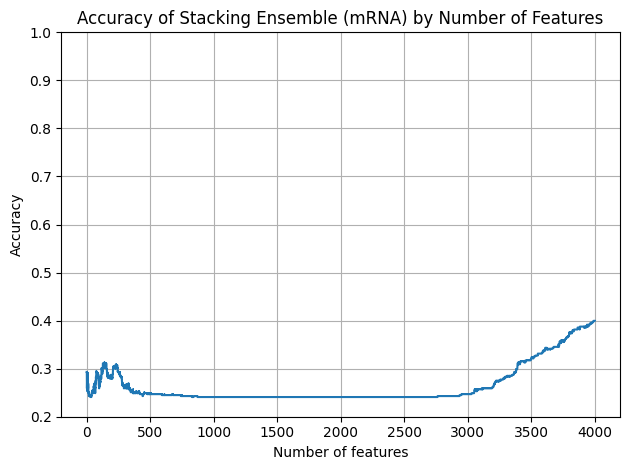

In [43]:
x = list(range(0, 4000))
plt.plot(x, fs_rna.scores_, marker=',')
plt.ylim([0.2, 1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.title('Accuracy of Stacking Ensemble (mRNA) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [58]:
def get_score_range(fs, estimators, data, target, start, end):
        scores_ = []

        cv = KFold(n_splits=fs.cv, random_state=1, shuffle=True)
        for train_index, test_index in cv.split(data):
            
            X, X_test = data.iloc[train_index, :], data.iloc[test_index, :]
            y, y_test = target.iloc[train_index], target.iloc[test_index]
            
            # Fitting base estimators 
            for name, estimator in estimators:
                estimator.fit(X, y)
            
            # Create the transformer to impute missing values
            imputer = SimpleImputer(strategy='mean')
            level1 = Pipeline(steps=[('prep', imputer), ('lr', LogisticRegression())])
            
            # Fitting stacking model
            fs.model = StackingClassifier(estimators, final_estimator=level1, cv='prefit')
            fs.model.fit(X, y)
            
            scores = []

            for i in tqdm(range(start, end)):
                indices = fs.best_n_features(i)
                temp = X_test.copy()
                all_cols = temp.columns
                selected_cols = np.delete(np.arange(len(all_cols)), indices)
                temp.iloc[:, selected_cols] = 0
                y_pred = fs.model.predict(temp)
                score = accuracy_score(y_test, y_pred)
                scores.append(score)
        
            scores_.append(scores)
        
        scores_ = np.average(scores_, axis=0)
        
        return scores_

In [62]:
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['mrna'] if x == name)]

scores = get_score_range(fs_rna, estimator_list, data_reduced['mrna'], target['mrna'], 0, 6000)

100%|██████████| 6000/6000 [04:12<00:00, 23.74it/s]


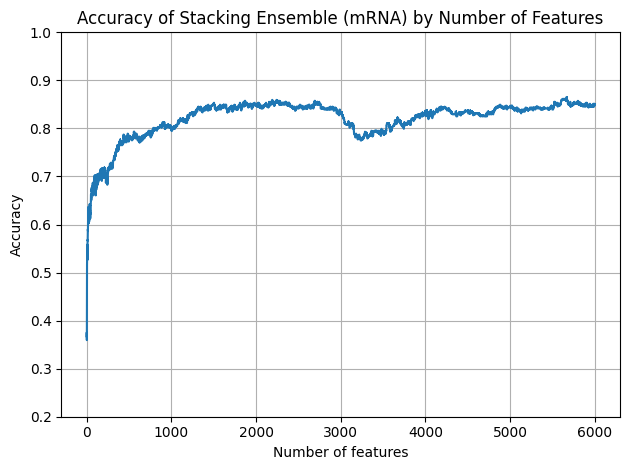

In [64]:
x = list(range(0, 6000))
plt.plot(x, scores, marker=',')
plt.ylim([0.2, 1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.title('Accuracy of Stacking Ensemble (mRNA) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [65]:
n_features = np.argmax(scores)
print(n_features)

5668


In [96]:
features = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500]
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['mrna'] if x == name)]
score_list = []

for n in tqdm(features):
    
    indices = fs_rna.best_n_features(n)
    columns = data_reduced['mrna'].columns[indices]

    new_data['mrna'] = data_reduced['mrna'].loc[:, columns]
    
    # Perform 5-fold cross-validation
    model, scores = trainStackingModel(estimator_list, LogisticRegression(), new_data['mrna'], target['mrna'], metrics={'f1':make_scorer(f1_score, average='weighted'),
             'accuracy':'accuracy'}, cv=5)
    
    score_list.append(scores)

    metrics = pd.concat([metrics, pd.DataFrame([[n, '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)

metrics

100%|██████████| 13/13 [05:53<00:00, 27.23s/it]


,model,f1_score,accuracy
0,500,0.909 +/- 0.034,0.908 +/- 0.035
1,1000,0.916 +/- 0.033,0.916 +/- 0.033
2,1500,0.922 +/- 0.020,0.922 +/- 0.021
3,2000,0.913 +/- 0.024,0.914 +/- 0.023
4,2500,0.916 +/- 0.021,0.916 +/- 0.022
5,3000,0.916 +/- 0.020,0.916 +/- 0.019
6,3500,0.920 +/- 0.020,0.920 +/- 0.020
7,4000,0.912 +/- 0.019,0.912 +/- 0.019
8,4500,0.918 +/- 0.018,0.918 +/- 0.018
9,5000,0.916 +/- 0.014,0.916 +/- 0.015


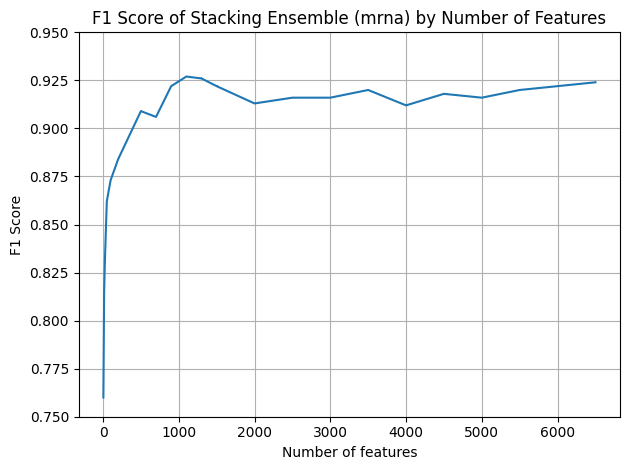

In [38]:
x = [5, 15, 25, 50, 100, 200, 500, 700, 900, 1100, 1300, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500]
y = [0.760, 0.815, 0.831, 0.862, 0.873, 0.884, 0.909, 0.906, 0.922, 0.927, 0.926, 0.922, 0.913, 0.916, 0.916, 0.920, 0.912, 0.918, 0.916, 0.920, 0.922, 0.924]
plt.plot(x, y, marker=',')
plt.ylim([0.75, 0.95])
plt.ylabel('F1 Score')
plt.xlabel('Number of features')
plt.title('F1 Score of Stacking Ensemble (mrna) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [60]:
mrna = pd.read_pickle("mrna_reduced.pkl")

In [57]:

# Finding the n most important features (based on maximum)
#indices = fs_rna.best_n_features(1300)
#columns = data_reduced['mrna'].columns[indices]

#new_data['mrna'] = data_reduced['mrna'].loc[:, columns]

col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)

estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['mrna'] if x == name)]

model, scores = trainStackingModel(estimator_list, LogisticRegression(), mrna.iloc[:, : 1100], target['mrna'], metrics={'f1':make_scorer(f1_score, average='weighted'),
         'accuracy':'accuracy'}, cv=5)

metrics = pd.concat([metrics, pd.DataFrame([['mrna', '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)

metrics

,model,f1_score,accuracy
0,mrna,0.927 +/- 0.028,0.926 +/- 0.028


In [105]:
new_data['mrna'].to_pickle("mrna_reduced.pkl")

## Prot:

In [21]:
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['prot'] if x == name)]

fs = EnsembleFeatureSelection(estimator_list, 3)
fs.fit(data_reduced['prot'], target['prot'])

100%|██████████| 3121/3121 [10:31<00:00,  4.94it/s]


In [30]:
# Finding the 100 most important features
indices = fs.best_n_features(100)
columns = data_reduced['prot'].columns[indices]

# Converting to a string for enrichment analysis
print(','.join(columns))
print(fs.avg_importances[indices])

KRT7,PGLYRP1,MYL12B,PM20D2,CLC,TIPIN,OGFOD3,UCHL1,LALBA,APPBP2,DCAF10,FBXO9,DBI,PYDC1,KRT81,FCN3,UBE2J1,TMCO6,SOX9,UBA52,UAP1,LCN2,CLSTN1,DEFA3,OTUD5,PAPSS2,TELO2,CARTPT,WDR41,FAM129A,SCGN,HSD17B7,GRB14,RARRES1,ICAM3,PADI4,LMX1B,MTL5,HSPA4L,TG,CHMP3,MUC16,VCAN,SEC14L1,MUCL1,VTCN1,FAM111B,CLSTN2,IGSF1,C10orf54,KIAA1147,TMX4,ATP1B1,TRUB2,PSAT1,PRTN3,TNFAIP2,NT5C2,IRF7,SMOC1,COLEC12,CRABP1,PROM1,PRNP,AZU1,KBTBD2,NPNT,SLC34A2,PRG2,PRPF40B,KRT23,TSPAN6,GLDC,NUSAP1,KRT16,CXCL12,TVP23C,NCCRP1,PTX3,TMEM165,POR,IMPA2,TSPYL5,TMEM189-UBE2V1,INHBA,TMEM230,INO80C,INPP4B,CTHRC1,SNX24,SHPK,GLRX,SIAH1,CNNM3,DNAL1,CALML5,RETN,S100A1,HMGN3,EGFR
[0.01932773 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392
 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392
 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392
 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392
 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392
 0.00980392 0.00980392 0.00980

100%|██████████| 2000/2000 [06:33<00:00,  5.09it/s]


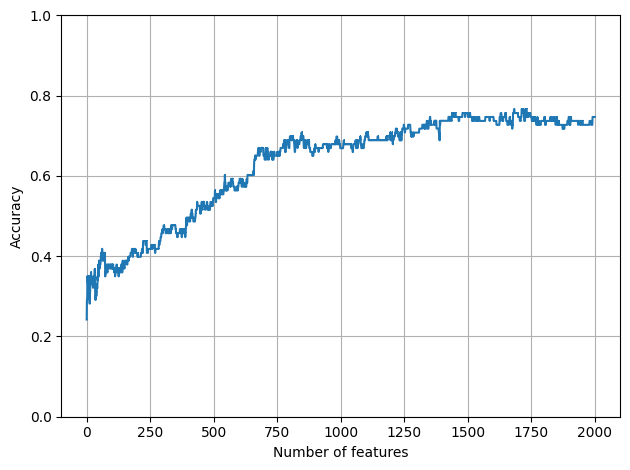

In [26]:
# Getting scores for each feature subset and plotting scores
fs.get_scores(data_reduced['prot'], target['prot'], 2000)

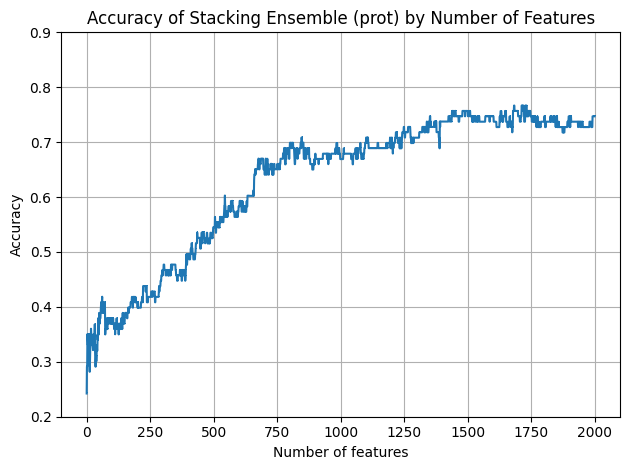

In [28]:
x = list(range(0, 2000))
plt.plot(x, fs.scores_, marker=',')
plt.ylim([0.2, 0.9])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.title('Accuracy of Stacking Ensemble (prot) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [46]:
n_features = fs.scores_.argmax()
print(n_features)

1682


We see that performance plateaus at around 1700 features.

In [25]:
features = [5, 10, 15, 20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['prot'] if x == name)]
score_list = []

for n in tqdm(features):
    
    indices = fs.best_n_features(n)
    columns = data_reduced['prot'].columns[indices]

    new_data['prot'] = data_reduced['prot'].loc[:, columns]
    
    # Perform 5-fold cross-validation
    model, scores = trainStackingModel(estimator_list, LogisticRegression(), new_data['prot'], target['prot'], metrics={'f1':make_scorer(f1_score, average='weighted'),
             'accuracy':'accuracy'}, cv=5)

    metrics = pd.concat([metrics, pd.DataFrame([[n, '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)
    score_list.append(np.mean(scores['test_f1']))
    
metrics

 94%|█████████▍| 32/34 [00:40<00:04,  2.14s/it]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_base.py:440: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
100%|██████████| 34/34 [00:45<00:00,  1.32s/it]


,model,f1_score,accuracy
0,5,0.336 +/- 0.089,0.369 +/- 0.078
1,10,0.372 +/- 0.028,0.428 +/- 0.025
2,15,0.396 +/- 0.050,0.437 +/- 0.032
3,20,0.416 +/- 0.041,0.466 +/- 0.025
4,100,0.582 +/- 0.105,0.582 +/- 0.108
5,200,0.679 +/- 0.115,0.680 +/- 0.114
6,300,0.741 +/- 0.130,0.747 +/- 0.123
7,400,0.758 +/- 0.134,0.767 +/- 0.126
8,500,0.799 +/- 0.102,0.805 +/- 0.097
9,600,0.798 +/- 0.101,0.805 +/- 0.097


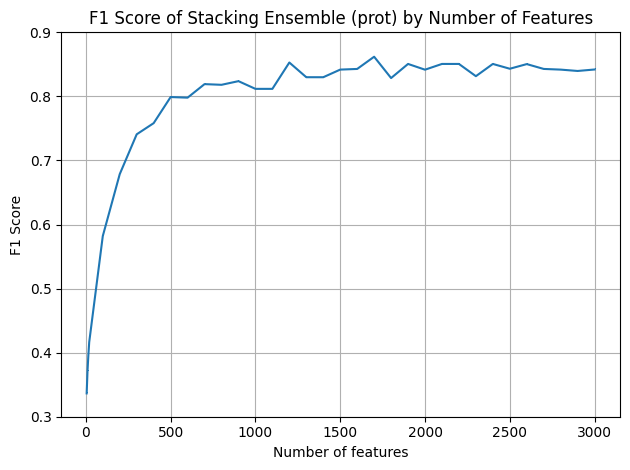

In [29]:
x = [500, 625, 750, 875, 1000, 1125, 1250, 1375, 1500, 1625, 1700, 1750, 2000, 2250, 2500, 2750, 3000]
y = [0.799, 0.808, 0.819, 0.842, 0.812, 0.821, 0.824, 0.851, 0.842, 0.852, 0.862, 0.820, 0.842, 0.851, 0.843, 0.843, 0.842]
plt.plot(features, score_list, marker=',')
plt.ylim([0.30, 0.9])
plt.ylabel('F1 Score')
plt.xlabel('Number of features')
plt.title('F1 Score of Stacking Ensemble (prot) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

The score is highest at 1700 features.

In [111]:
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)

# Finding the 1700 most important features
indices = fs.best_n_features(1700)
columns = data_reduced['prot'].columns[indices]

new_data['prot'] = data_reduced['prot'].loc[:, columns]

estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['prot'] if x == name)]

# Performing 10-fold cross-validation to get update metric
model, scores = trainStackingModel(estimator_list, LogisticRegression(), new_data['prot'], target['prot'], metrics={'f1':make_scorer(f1_score, average='weighted'),
         'accuracy':'accuracy'}, cv=5)

metrics = pd.concat([metrics, pd.DataFrame([['prot', '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)

metrics

,model,f1_score,accuracy
0,prot,0.862 +/- 0.102,0.863 +/- 0.100


In [112]:
new_data['prot'].to_pickle("prot_reduced.pkl")

## Total

In [114]:
col_names = ['model', 'f1', 'accuracy']
stacking_metrics = pd.DataFrame(columns=col_names)
stacking_model = {}
scores = {}

for modality in datasets:
    print("dataset: " + modality)
    estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators[modality] if x == name)]
    
    stacking_model[modality], scores[modality] = trainStackingModel(estimator_list, LogisticRegression(), new_data[modality], target[modality], metrics=_metrics, cv=5)

    stacking_metrics = pd.concat([stacking_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores[modality]['test_f1']), np.std(scores[modality]['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores[modality]['test_accuracy']), np.std(scores[modality]['test_accuracy']))]], columns=col_names)], ignore_index=True)

dataset: cnv
dataset: mrna
dataset: prot


In [115]:
stacking_metrics

,model,f1,accuracy
0,cnv,0.748 +/- 0.027,0.758 +/- 0.031
1,mrna,0.926 +/- 0.030,0.926 +/- 0.030
2,prot,0.862 +/- 0.102,0.863 +/- 0.100


In [84]:
new_data['cnv'].to_csv('cnv_reduced.csv', index=False)
new_data['mrna'].to_csv('mrna_reduced.csv', index=False)
new_data['prot'].to_csv('prot_reduced.csv', index=False)

In [116]:
new_data['cnv'].to_pickle("cnv_reduced.pkl")
new_data['mrna'].to_pickle("mrna_reduced.pkl")
new_data['prot'].to_pickle("prot_reduced.pkl")

In [7]:
read_data = {}
read_data['cnv'] = pd.read_pickle("cnv_reduced.pkl")
read_data['mrna'] = pd.read_pickle("mrna_reduced.pkl")
read_data['prot'] = pd.read_pickle("prot_reduced.pkl")

## Base Learners

In [15]:
import warnings
warnings.filterwarnings('ignore')

model = LogisticRegression(solver='saga', multi_class='multinomial', random_state=1)

fs = BaseFeatureSelection(model, 3)
fs.fit(data_reduced['cnv'], target['cnv'])

100%|██████████| 7991/7991 [03:35<00:00, 37.00it/s]


In [17]:
indices = fs.best_n_features(100)
columns = data_reduced['cnv'].columns[indices]
print(indices)
print(','.join(columns))
print(fs.avg_importances[indices])

[1569 7965 5958 2030 5020 2337 6517  355 6687 5638 5696  410 6816 7430
  714 2775 6202 2349 1516 7095 1829 2668 5601 1619 4062 3783  206 1438
 3127  586  205 7304 1688 5310 5324 5323 5311 5322 5316 5312 5314 5320
 5315 5319 5318 5317 5321 5313    0 5326 5353 5352 5351 5350 5348 5347
 5346 5345 5344 5343 5342 5341 5325 5340 5338 5337 5336 5335 5334 5333
 5332 5331 5309 5329 5328 5327 5339 5330 5301 5307 5276 5275 5274 5273
 5272 5271 5270 5269 5268 5267 5266 5265 5277 5264 5262 5261 5260 5259
 5258 5257]
PRKAA2,MIR6884,PGAP3,THRA,XYLT2,DGKE,EME1,COL1A1,TMEM92,MIEN1,PPP1R9B,CSF3,SAMD14,COA6,GAS6,MED24,ZPBP2,TCAP,PNMT,GSDMA,SGCA,NR1D1,PPP1R1B,PSMD3,MRPL27,DKK4,C8B,PDK2,STARD3,ERBB2,C8A,TMEM255B,RARRES2,TMC7,JADE1,CEP76,ACTR5,PAQR6,SPEF2,ATAD5,C2orf54,LPPR3,MRM1,ZNF696,SYNPO2L,MAP6D1,ERMP1,SETD6,A1BG,SCD5,MROH9,CCDC170,TRIM46,CCDC176,BICC1,C3orf36,ZNF606,ADAMTS20,TMEM62,C14orf159,FAM188A,PHC3,DNAJC22,FAM192A,TMEM156,C10orf88,TRAPPC13,ESRP2,GREB1L,ELOVL7,PLEKHH3,POF1B,NAA60,FRMD1,WLS,WDR76,

The top 33 have an individual impact on accuracy.

In [82]:
indices = fs.best_n_features(33)
columns = data_reduced['cnv'].columns[indices]
print(','.join(columns))

PRKAA2,MIR6884,PGAP3,THRA,XYLT2,DGKE,EME1,COL1A1,TMEM92,MIEN1,PPP1R9B,CSF3,SAMD14,COA6,GAS6,MED24,ZPBP2,TCAP,PNMT,GSDMA,SGCA,NR1D1,PPP1R1B,PSMD3,MRPL27,DKK4,C8B,PDK2,STARD3,ERBB2,C8A,TMEM255B,RARRES2


In [84]:
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')

features = [5, 20, 50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000]
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)
score_list = []
cv = KFold(n_splits=5, random_state=1, shuffle=True)
new_base_data = {}

model = ('lr', LogisticRegression(solver='saga', multi_class='multinomial', random_state=1))
pipe=Pipeline(steps=[('data_prep',transformer),model])

for n in tqdm(features):
    
    indices = fs.best_n_features(n)
    columns = data_reduced['cnv'].columns[indices]

    new_base_data['cnv'] = data_reduced['cnv'].loc[:, columns]
    
    # Perform 5-fold cross-validation
    scores = cross_validate(model[1], new_base_data['cnv'], target['cnv'], scoring=_metrics, cv=cv, n_jobs = -1, error_score='raise')

    metrics = pd.concat([metrics, pd.DataFrame([[n, '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)
    score_list.append(np.mean(scores['test_f1']))
    
metrics

  5%|▍         | 1/21 [00:00<00:13,  1.43it/s]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 2/21 [00:01<00:09,  2.10it/s]/opt/tljh/user/lib

 48%|████▊     | 10/21 [00:08<00:14,  1.36s/it]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 11/21 [00:10<00:15,  1.53s/it]/opt/tljh/user/l

 90%|█████████ | 19/21 [00:36<00:07,  3.61s/it]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 20/21 [00:41<00:03,  3.89s/it]/opt/tljh/user/l

,model,f1_score,accuracy
0,5,0.452 +/- 0.042,0.539 +/- 0.037
1,20,0.508 +/- 0.043,0.555 +/- 0.030
2,50,0.616 +/- 0.074,0.639 +/- 0.065
3,100,0.673 +/- 0.053,0.689 +/- 0.050
4,200,0.708 +/- 0.040,0.720 +/- 0.042
5,500,0.737 +/- 0.029,0.744 +/- 0.029
6,1000,0.743 +/- 0.049,0.752 +/- 0.046
7,1500,0.735 +/- 0.057,0.744 +/- 0.054
8,2000,0.734 +/- 0.057,0.742 +/- 0.054
9,2500,0.733 +/- 0.054,0.742 +/- 0.051


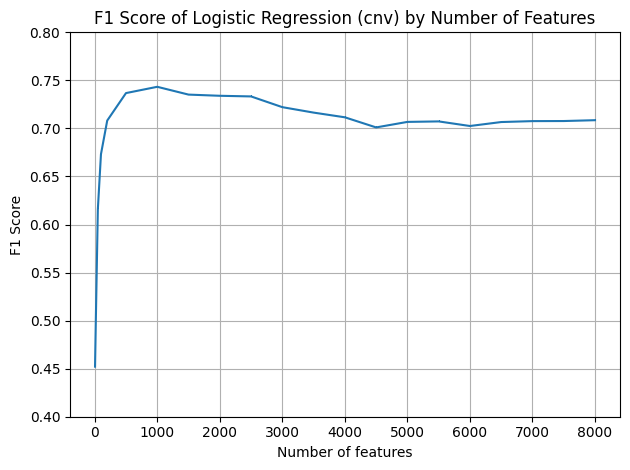

In [87]:
x = features
y = score_list
plt.plot(x, y, marker=',')
plt.ylim([0.4, 0.80])
plt.ylabel('F1 Score')
plt.xlabel('Number of features')
plt.title('F1 Score of Logistic Regression (cnv) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

### mRNA

In [67]:
import warnings
warnings.filterwarnings('ignore')

model = LogisticRegression(solver='saga', multi_class='multinomial', random_state=1)
fs = BaseFeatureSelection(model, 3)
fs.fit(data_reduced['mrna'], target['mrna'])

indices = fs.best_n_features(100)
columns = data_reduced['mrna'].columns[indices]
print(indices)
print(','.join(columns))

100%|██████████| 6428/6428 [02:19<00:00, 46.22it/s]

[1035 4361 4162 4250 4738 5826  985  338 3834  991 4723 2884 3856 2870
 4698 2867 4688 5886 4715 5817 3810 2111 5687  909 3021 3016 3012  419
 5733 1511 5747 3757  383 4776 3792  370 2103 1558 4807 3885  293 2831
 1461 4576 2232 1456 6016 6023 3986 1463 1445 1101 4540  188 4513 1411
 1134 2664 2245 1464 5996  244 1500 1036 4655 4646  276 4645 2191 4641
 5939 5958 4613 1477  252 2780 5979 5980 3935 3037 2034 3050 3682 3470
 3473  744 5340 5343 5116 5112 5320 3291 1881  604 5371 3495 3496 3269
 1895 1878]
MYBPC1,SLC25A48,MYO3B,CBLN2,OTOGL,DDX3P1,MIP,HAPLN1,TDRD12,MMP1,PGBD3,ELOVL2,TMEM132C,DCHS2,MAP7D2,CFAP46,LINC01619,CEP164P1,PYDC1,RPS27P29,AOC4P,LEFTY1,SEC14L6,LCP1,SCN3B,PRR11,OGDHL,DRD2,MYHAS,TK1,RPL3P9,RGS8,DACH1,LOC284080,SYT8,CYP2B7P,DPYSL4,U2AF1,SMIM24,SDR42E1,CLCNKA,SNTG2,SYN2,CERS3,GPR182,SULT1A3,ASAP1-IT2,ALKBH3-AS1,LRG1,SYT1,SSTR1,OMG,FOXD4L1,CA12,PIANP,SLC15A2,SERPINA5,ST8SIA5,RHOBTB3,SYT5,LINC00327,CDH4,LEFTY2,MYBL2,PCGF7P,SPESP1,CHRM1,LINC00315,ADAMTS8,RSPH10B,LOC100505504

In [73]:
indices = fs.best_n_features(100)
print(fs.avg_importances[indices])

[0.00401606 0.00401606 0.00401606 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.0020

In [74]:
import warnings
warnings.filterwarnings('ignore')

features = [5, 20, 50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500]
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)
score_list = []
cv = KFold(n_splits=5, random_state=1, shuffle=True)
new_base_data = {}

model = ('lr', LogisticRegression(solver='saga', multi_class='multinomial', random_state=1))
pipe=Pipeline(steps=[('data_prep',transformer),model])

for n in tqdm(features):
    
    indices = fs.best_n_features(n)
    columns = data_reduced['mrna'].columns[indices]

    new_base_data['mrna'] = data_reduced['mrna'].loc[:, columns]
    
    # Perform 5-fold cross-validation
    scores = cross_validate(model[1], new_base_data['mrna'], target['mrna'], scoring=_metrics, cv=cv, n_jobs = -1, error_score='raise')

    metrics = pd.concat([metrics, pd.DataFrame([[n, '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)
    score_list.append(np.mean(scores['test_f1']))
    
metrics

  0%|          | 0/18 [00:00<?, ?it/s]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 1/18 [00:00<00:11,  1.54it/s]/opt/tljh/user/lib/python3

 50%|█████     | 9/18 [00:06<00:10,  1.11s/it]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 10/18 [00:08<00:10,  1.35s/it]/opt/tljh/user/li

100%|██████████| 18/18 [00:32<00:00,  1.79s/it]


,model,f1_score,accuracy
0,5,0.517 +/- 0.033,0.550 +/- 0.025
1,20,0.665 +/- 0.018,0.669 +/- 0.027
2,50,0.704 +/- 0.025,0.707 +/- 0.027
3,100,0.777 +/- 0.034,0.777 +/- 0.033
4,200,0.765 +/- 0.040,0.763 +/- 0.039
5,500,0.837 +/- 0.026,0.837 +/- 0.025
6,1000,0.859 +/- 0.032,0.860 +/- 0.031
7,1500,0.858 +/- 0.029,0.858 +/- 0.029
8,2000,0.855 +/- 0.033,0.856 +/- 0.032
9,2500,0.863 +/- 0.027,0.864 +/- 0.025


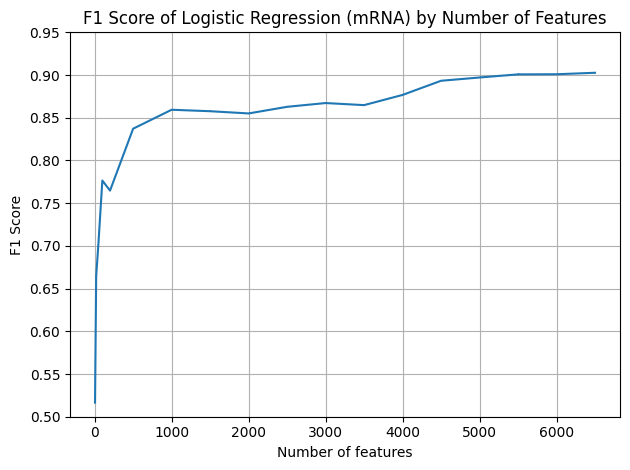

In [79]:
x = features
y = score_list
plt.plot(x, y, marker=',')
plt.ylim([0.5, 0.95])
plt.ylabel('F1 Score')
plt.xlabel('Number of features')
plt.title('F1 Score of Logistic Regression (mRNA) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

### prot

In [10]:
import warnings
warnings.filterwarnings('ignore')

model = LogisticRegression(solver='saga', multi_class='multinomial', random_state=1)
fs = BaseFeatureSelection(model, 3)
fs.fit(data_reduced['prot'], target['prot'])

100%|██████████| 3121/3121 [00:32<00:00, 95.99it/s]


In [45]:
indices = fs.best_n_features(100)
columns = data_reduced['prot'].columns[indices]
print(indices)
print(','.join(columns))

[2366 2194 2919 1565 2076 1996  863 2853 2643  548 2075 2077 2078 2079
 2080 2081    0 2084 2085 2086 2087 2088 2089 2090 2091 2082 2083 2072
 2073 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064
 2065 2066 2067 2068 2069 2070 2071 2092 2074 2093 2096 2095 2120 2121
 2122 2123 2124 2125 2126 2127 2128 2119 2129 2131 2132 2133 2134 2135
 2136 2137 2138 2139 2130 2094 2118 2116 2051 2097 2098 2099 2100 2101
 2102 2103 2104 2117 2105 2107 2108 2109 2110 2111 2112 2113 2114 2115
 2106 2050]
S100A1,PYDC1,TUBB2B,MAPT,POF1B,PGR,ERBB2,TPRG1,STC2,CLEC3A,PODXL,POLA2,POLB,POLDIP2,POLE,POLE4,A2M,POLR3GL,POMP,POP4,POR,POSTN,POT1,POTEF,PPA1,POLG2,POLI,PNPO,POC1B,PLG,PLIN1,PLIN2,PLIN4,PLIN5,PLK1,PLOD1,PLOD2,PLS1,PLTP,PLVAP,PLXDC2,PM20D2,PMP2,PMS1,PMVK,PNMT,PNP,PNPLA4,PNPLA8,PPA2,PODN,PPAPDC2,PPFIBP2,PPDPF,PRELP,PREP,PREX1,PRG2,PRKAA2,PRKAG2,PRKAR1B,PRKCA,PRKCB,PRCC,PRKCDBP,PRKD1,PRKRIP1,PRMT3,PRMT7,PRNP,PRODH,PROM1,PROS1,PROSC,PRKCH,PPBP,PRC1,PPT1,PLEKHS1,PPIAL4G,PPIB,PPIC,PPID,PPIH,

In [40]:
fs.avg_importances[indices]

array([0.00980392, 0.00980392, 0.00980392, 0.00980392, 0.00980392,
       0.00980392, 0.00980392, 0.00980392, 0.00980392, 0.00980392,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Here we can see that only the first 10 features actually make a difference in the overall score when set to 0.

In [64]:
import warnings
warnings.filterwarnings('ignore')

features = [5, 10, 15, 20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)
score_list = []
cv = KFold(n_splits=5, random_state=1, shuffle=True)
new_base_data = {}

model = ('lr', LogisticRegression(solver='saga', multi_class='multinomial', random_state=1))
pipe=Pipeline(steps=[('data_prep',transformer),model])

for n in tqdm(features):
    
    indices = fs.best_n_features(n)
    columns = data_reduced['prot'].columns[indices]

    new_base_data['prot'] = data_reduced['prot'].loc[:, columns]
    
    # Perform 5-fold cross-validation
    scores = cross_validate(model[1], new_base_data['prot'], target['prot'], scoring=_metrics, cv=cv, n_jobs = -1, error_score='raise')

    metrics = pd.concat([metrics, pd.DataFrame([[n, '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)
    score_list.append(np.mean(scores['test_f1']))
    
metrics

  3%|▎         | 1/34 [00:00<00:22,  1.45it/s]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 2/34 [00:00<00:14,  2.14it/s]/opt/tljh/user/lib

 29%|██▉       | 10/34 [00:03<00:08,  2.81it/s]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 11/34 [00:03<00:06,  3.60it/s]/opt/tljh/user/l

 56%|█████▌    | 19/34 [00:05<00:03,  3.78it/s]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 20/34 [00:05<00:03,  3.50it/s]/opt/tljh/user/l

 82%|████████▏ | 28/34 [00:08<00:02,  2.49it/s]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 29/34 [00:09<00:02,  2.42it/s]/opt/tljh/user/l

,model,f1_score,accuracy
0,5,0.526 +/- 0.133,0.527 +/- 0.128
1,10,0.516 +/- 0.093,0.514 +/- 0.088
2,15,0.577 +/- 0.110,0.572 +/- 0.113
3,20,0.585 +/- 0.058,0.582 +/- 0.054
4,100,0.617 +/- 0.062,0.612 +/- 0.056
5,200,0.706 +/- 0.083,0.710 +/- 0.083
6,300,0.725 +/- 0.104,0.727 +/- 0.101
7,400,0.771 +/- 0.094,0.776 +/- 0.091
8,500,0.762 +/- 0.081,0.767 +/- 0.077
9,600,0.772 +/- 0.043,0.776 +/- 0.041


In [65]:
metrics

,model,f1_score,accuracy
0,5,0.526 +/- 0.133,0.527 +/- 0.128
1,10,0.516 +/- 0.093,0.514 +/- 0.088
2,15,0.577 +/- 0.110,0.572 +/- 0.113
3,20,0.585 +/- 0.058,0.582 +/- 0.054
4,100,0.617 +/- 0.062,0.612 +/- 0.056
5,200,0.706 +/- 0.083,0.710 +/- 0.083
6,300,0.725 +/- 0.104,0.727 +/- 0.101
7,400,0.771 +/- 0.094,0.776 +/- 0.091
8,500,0.762 +/- 0.081,0.767 +/- 0.077
9,600,0.772 +/- 0.043,0.776 +/- 0.041


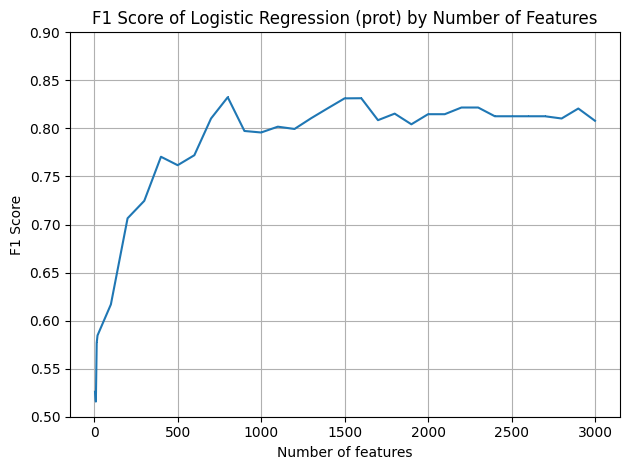

In [66]:
x = features
y = score_list
plt.plot(x, y, marker=',')
plt.ylim([0.5, 0.9])
plt.ylabel('F1 Score')
plt.xlabel('Number of features')
plt.title('F1 Score of Logistic Regression (prot) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

# Mega-Ensemble

In [8]:
# Dictionary of best estimators for each modality
selected_estimators = {
    'cnv': ['logistic', 'xgb', 'deep_nn'],
    'mrna': ['logistic', 'deep_nn'],
    'prot': ['logistic', 'elasticnet']
}

In [9]:
def trainModel(model, x_train, y_train, n_folds):
    cv = KFold(n_splits= n_folds, random_state=1)
    scores = cross_validate(model, x_train, y_train, scoring=_metrics, cv=cv, n_jobs=-1)
    y_pred = cross_val_predict(model, x_train, y_train, cv=cv, method='predict') 
    return scores, y_pred

In [10]:
read_data = {}
read_data['cnv'] = pd.read_pickle("cnv_reduced.pkl")
read_data['mrna'] = pd.read_pickle("mrna_reduced.pkl")
read_data['prot'] = pd.read_pickle("prot_reduced.pkl")

In [11]:
# Merge the data frames by the common index
data_merged = pd.merge(read_data['cnv'], read_data['mrna'].iloc[:, :1100], left_index=True, right_index=True)
data_merged = pd.merge(data_merged, read_data['prot'], left_index=True, right_index=True)
# Merge the data frames by the common index
target_merged = pd.merge(target['cnv'], target['mrna'], left_index=True, right_index=True)
target_merged = pd.merge(target_merged, target['prot'], left_index=True, right_index=True)

In [12]:
x_merged = {}
y_merged = {}
x_merged['cnv'] = data_merged.iloc[:, :4000]
x_merged['mrna'] = data_merged.iloc[:, 4000:5100]
x_merged['prot'] = data_merged.iloc[:, 5100:6800]
y_merged['cnv'] = target_merged.iloc[:, 0]
y_merged['mrna'] = target_merged.iloc[:, 1]
y_merged['prot'] = target_merged.iloc[:, 2]

In [13]:
x_merged['prot']

,KRT7,PGLYRP1,MYL12B_y,PM20D2_y,CLC,TIPIN,OGFOD3_y,UCHL1,LALBA,APPBP2,...,CLIC3,COL5A2,CEP97,CEP68,CCDC174,CCDC43_y,CCDC6,CCDC61,CCDC64B_y,CCDC8
TCGA-A2-A0CM,-0.252781,-0.652407,-0.458958,0.466743,-0.804091,-0.168741,-0.142518,0.512100,-2.628424,-0.036513,...,1.213030,0.091136,-0.025976,-0.318504,0.490197,-0.025280,-0.032032,-0.107731,1.004624,-0.063571
TCGA-A2-A0D0,-0.859379,1.245757,1.655324,1.079847,1.974396,-1.752400,0.816740,0.863305,-1.511417,1.040766,...,0.163853,-1.063527,-0.977139,-0.651553,1.015809,-1.175857,-0.583200,0.808520,-0.776157,-3.061733
TCGA-A2-A0D1,-0.951058,-2.206286,1.468337,-2.054043,-0.708302,1.664259,0.241013,-0.817346,-1.951375,0.268673,...,-0.087111,-0.376770,-0.316669,-2.303263,1.120176,-1.714018,-0.492726,0.430449,-0.802229,-1.243608
TCGA-A2-A0D2,-0.567193,-0.311477,-0.058518,0.595648,-0.537435,0.299439,0.125524,-0.571720,-2.584327,-0.338144,...,-0.402826,0.281776,0.155579,-0.338223,0.063009,0.121584,0.036171,-0.093096,-0.588578,0.485521
TCGA-A2-A0EQ,-0.630218,-0.865866,-0.587042,-0.651174,1.358506,-0.112551,-0.154029,-0.075283,-2.260237,-0.237436,...,-0.270774,-0.438922,-0.143363,-0.670775,0.005408,-0.176620,0.139030,-0.337895,-0.669885,-0.352879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-E2-A150,-0.062429,-0.231925,1.052740,0.499366,-0.600886,-1.330044,-1.365431,-0.793046,-1.823209,-0.130041,...,0.270114,-0.485456,0.740438,0.154211,-0.241471,-1.104169,-0.513908,-1.163599,-0.189928,-0.630504
TCGA-E2-A154,-0.818751,-2.027370,0.536328,-0.819021,-1.478825,-0.753507,-0.606596,0.030430,-2.293922,-0.138039,...,-0.219075,0.511677,0.367595,-0.505229,0.015657,-0.155406,-0.319213,0.630121,-0.062637,-0.260390
TCGA-E2-A158,-0.322649,-2.095276,-1.150418,0.779039,-1.703908,-0.730526,0.398101,1.534247,-2.101025,-0.727052,...,0.465464,-0.833423,-0.109132,0.311638,0.464657,-0.295954,-0.074305,-0.300610,0.482378,-0.222239
TCGA-E2-A159,1.145766,0.241650,1.849917,-0.253258,-0.091916,1.687692,1.093552,-0.600469,-1.208610,0.767249,...,0.511684,-0.285383,0.962732,-0.428801,-0.313495,-0.766961,-0.395624,-0.484622,0.738032,-3.252025


In [15]:
predictions = {}

# Create the transformer to impute missing values
imputer = SimpleImputer(strategy='mean')

level1 = Pipeline(steps=[('prep', imputer), ('lr', LogisticRegression())])
scores = {}

col_names = ['model', 'f1_score', 'accuracy']

modality_scores = pd.DataFrame(columns=col_names)

for modality in tqdm(datasets):
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    
    estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators[modality] if x == name)]
    model = Pipeline(steps=[('data_prep',transformer),('stacking',StackingClassifier(estimators=estimator_list, final_estimator=level1, cv=cv))])
    # define the stacking ensemble
    #model = StackingClassifier(estimators=estimator_list, final_estimator=level1, cv=cv)
    predictions[modality] = cross_val_predict(model, x_merged[modality], y_merged[modality], cv=cv, method='predict')
    scores[modality] = cross_validate(model, x_merged[modality], y_merged[modality], cv=cv, scoring=_metrics)
    
    modality_scores = pd.concat([modality_scores, pd.DataFrame([[modality, "%0.3f +/- %0.3f" % (scores[modality]['test_f1'].mean(), scores[modality]['test_f1'].std()), "%0.3f +/- %0.3f" % (scores[modality]['test_accuracy'].mean(), scores[modality]['test_accuracy'].std())]], columns=col_names)], ignore_index=True)
    

100%|██████████| 3/3 [02:08<00:00, 42.87s/it]


In [16]:
modality_scores

,model,f1_score,accuracy
0,cnv,0.694 +/- 0.062,0.699 +/- 0.056
1,mrna,0.868 +/- 0.058,0.865 +/- 0.063
2,prot,0.748 +/- 0.142,0.768 +/- 0.111


In [17]:
def trainBoostModel(x_train, y_train, n_folds, seed):
    cv = KFold(n_splits= n_folds, random_state=seed, shuffle=True)
    gbm = XGBClassifier(
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
        objective='multi:softprob', 
        random_state=1)
    
    scores = cross_validate(gbm, x_train, y_train, scoring=_metrics, cv=cv)
    
    return scores

In [18]:
esm_train = np.column_stack(list(predictions.values()))

stackModel_scores = trainBoostModel(esm_train, y_merged[modality], 5, 1)

print('F1: %.3f +/- %.3f' %(np.mean(stackModel_scores['test_f1']), np.std(stackModel_scores['test_f1'])))
print('Accuracy: %.3f +/- %.3f' %(np.mean(stackModel_scores['test_accuracy']), np.std(stackModel_scores['test_accuracy'])))

F1: 0.830 +/- 0.060
Accuracy: 0.826 +/- 0.063


In [19]:
modalities=['cnv', 'mRNA', 'prot', 'boosting']
scorers = []
scorers.append(scores['cnv'])
scorers.append(scores['mrna'])
scorers.append(scores['prot'])
scorers.append(stackModel_scores)

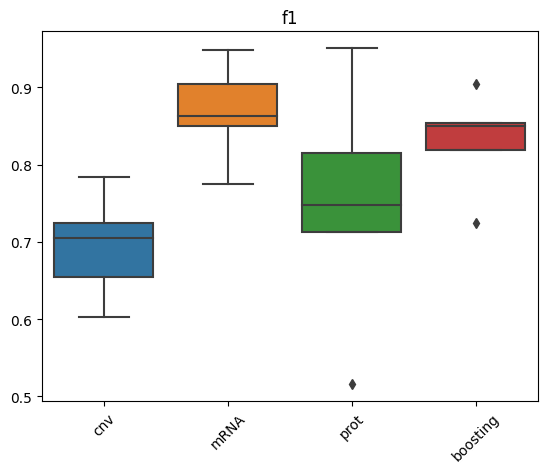

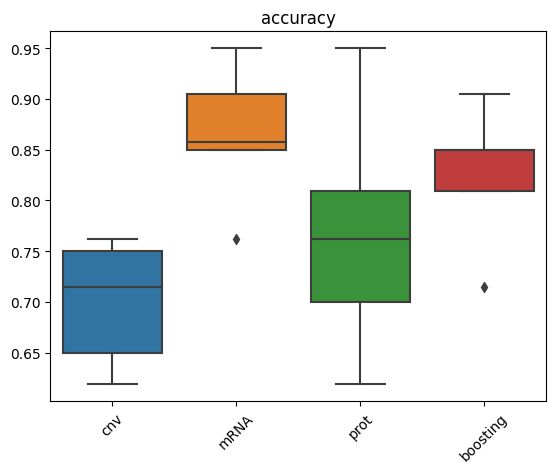

In [20]:
plot_scores(modalities, scorers)